In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import geopandas as gpd
import seaborn as sns
import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector
from scipy.stats import chi2_contingency

from data_loader import (
    get_users_df,
    get_reviews_df,
    get_beers_df,
    get_breweries_df,
    join_breweries_on_beers,
    merge_reviews,
)

In [2]:
reviews_path_ba = "data/matched_beer_data/ratings_ba.txt"
reviews_path_rb = "data/matched_beer_data/ratings_rb.txt"
users_path_ba = "data/users_ba.csv"
users_path_rb = "data/users_rb.csv"
breweries_path = "data/matched_beer_data/breweries.csv"
beers_path = "data/matched_beer_data/beers.csv"

In [3]:
states_climate = pd.read_csv("data/states_climate.csv")
states_climate.set_index("State", inplace=True)

In [29]:
climate_classifications = pd.read_csv("data/climate_classified.csv")
climate_classifications.set_index("climate", inplace=True)

climate_classifications.head(10)

,scheme,seasonal_precipitation,heat_level
climate,,,
Cfa,Temperate,without dry season,hot summer
Dfb,Continental,without dry season,warm summer
Dfa,Continental,without dry season,hot summer
Csa,Temperate,with dry season,hot summer
Dsb,Continental,with dry season,warm summer
Dfc,Continental,without dry season,cold summer
Csb,Temperate,with dry season,warm summer
Bsk,Dry,with dry season,cold summer
Cfb,Temperate,without dry season,warm summer


# Seeing the world through the lens of beer reviews


Beers are produced and consumed in every part of the world. One can thus wonder how beers around the world are perceived by different cultures. The interest of this project is to look into how beers from each country of production are judged and how specific countries judge others. As a side note, we will finally answer an age-old question : Are German beers actually good ?

On the one hand, we want to explore how a country’s beers are perceived both quantitatively and qualitatively. On the other hand, we will analyze the users’ ratings and look for significant patterns in how distinct countries rate other countries. For both of these analyses, we will dissect both the ratings and reviews to understand the feelings of the users. These findings will also be mapped to their climate to see if there is a correlation between a countries’ beer rating and the climate of said country. 


## 1) Loading data 

- All the pre-processing is done using the functions defined in `data_loader.py`.
- The preprocessing functions are described and documented in `data_loader.py`.
- We use the reviews/ ratings from both BeerAdvocate and RateBeer, and use the matched beers and breweries dataset to make sure that the names of the same beers are identical across the two datasets.
- Those two reviews/ ratings datasets are then merged and joined to the breweries, beers and users datasets to obtain a single complete dataframe of beer reviews.



In [6]:
users_df_ba = get_users_df(users_path_ba)
users_df_rb = get_users_df(users_path_rb)
ba_df = get_reviews_df(reviews_path_ba)
rb_df = get_reviews_df(reviews_path_rb)
breweries_df = get_breweries_df(breweries_path)
beers_df = get_beers_df(beers_path)
beers_df = join_breweries_on_beers(beers_df, breweries_df)
reviews_df = merge_reviews(ba_df, rb_df, beers_df, users_df_ba, users_df_rb)

## Is focusing on the US a feasible idea ?

### Numerical reviews

Here we want only the revieys of users in the US and then drop the beers with less than 10 reviews and see how many reviews per state there is after it.

 Percentage of ratings left:  97.43390674692388 %


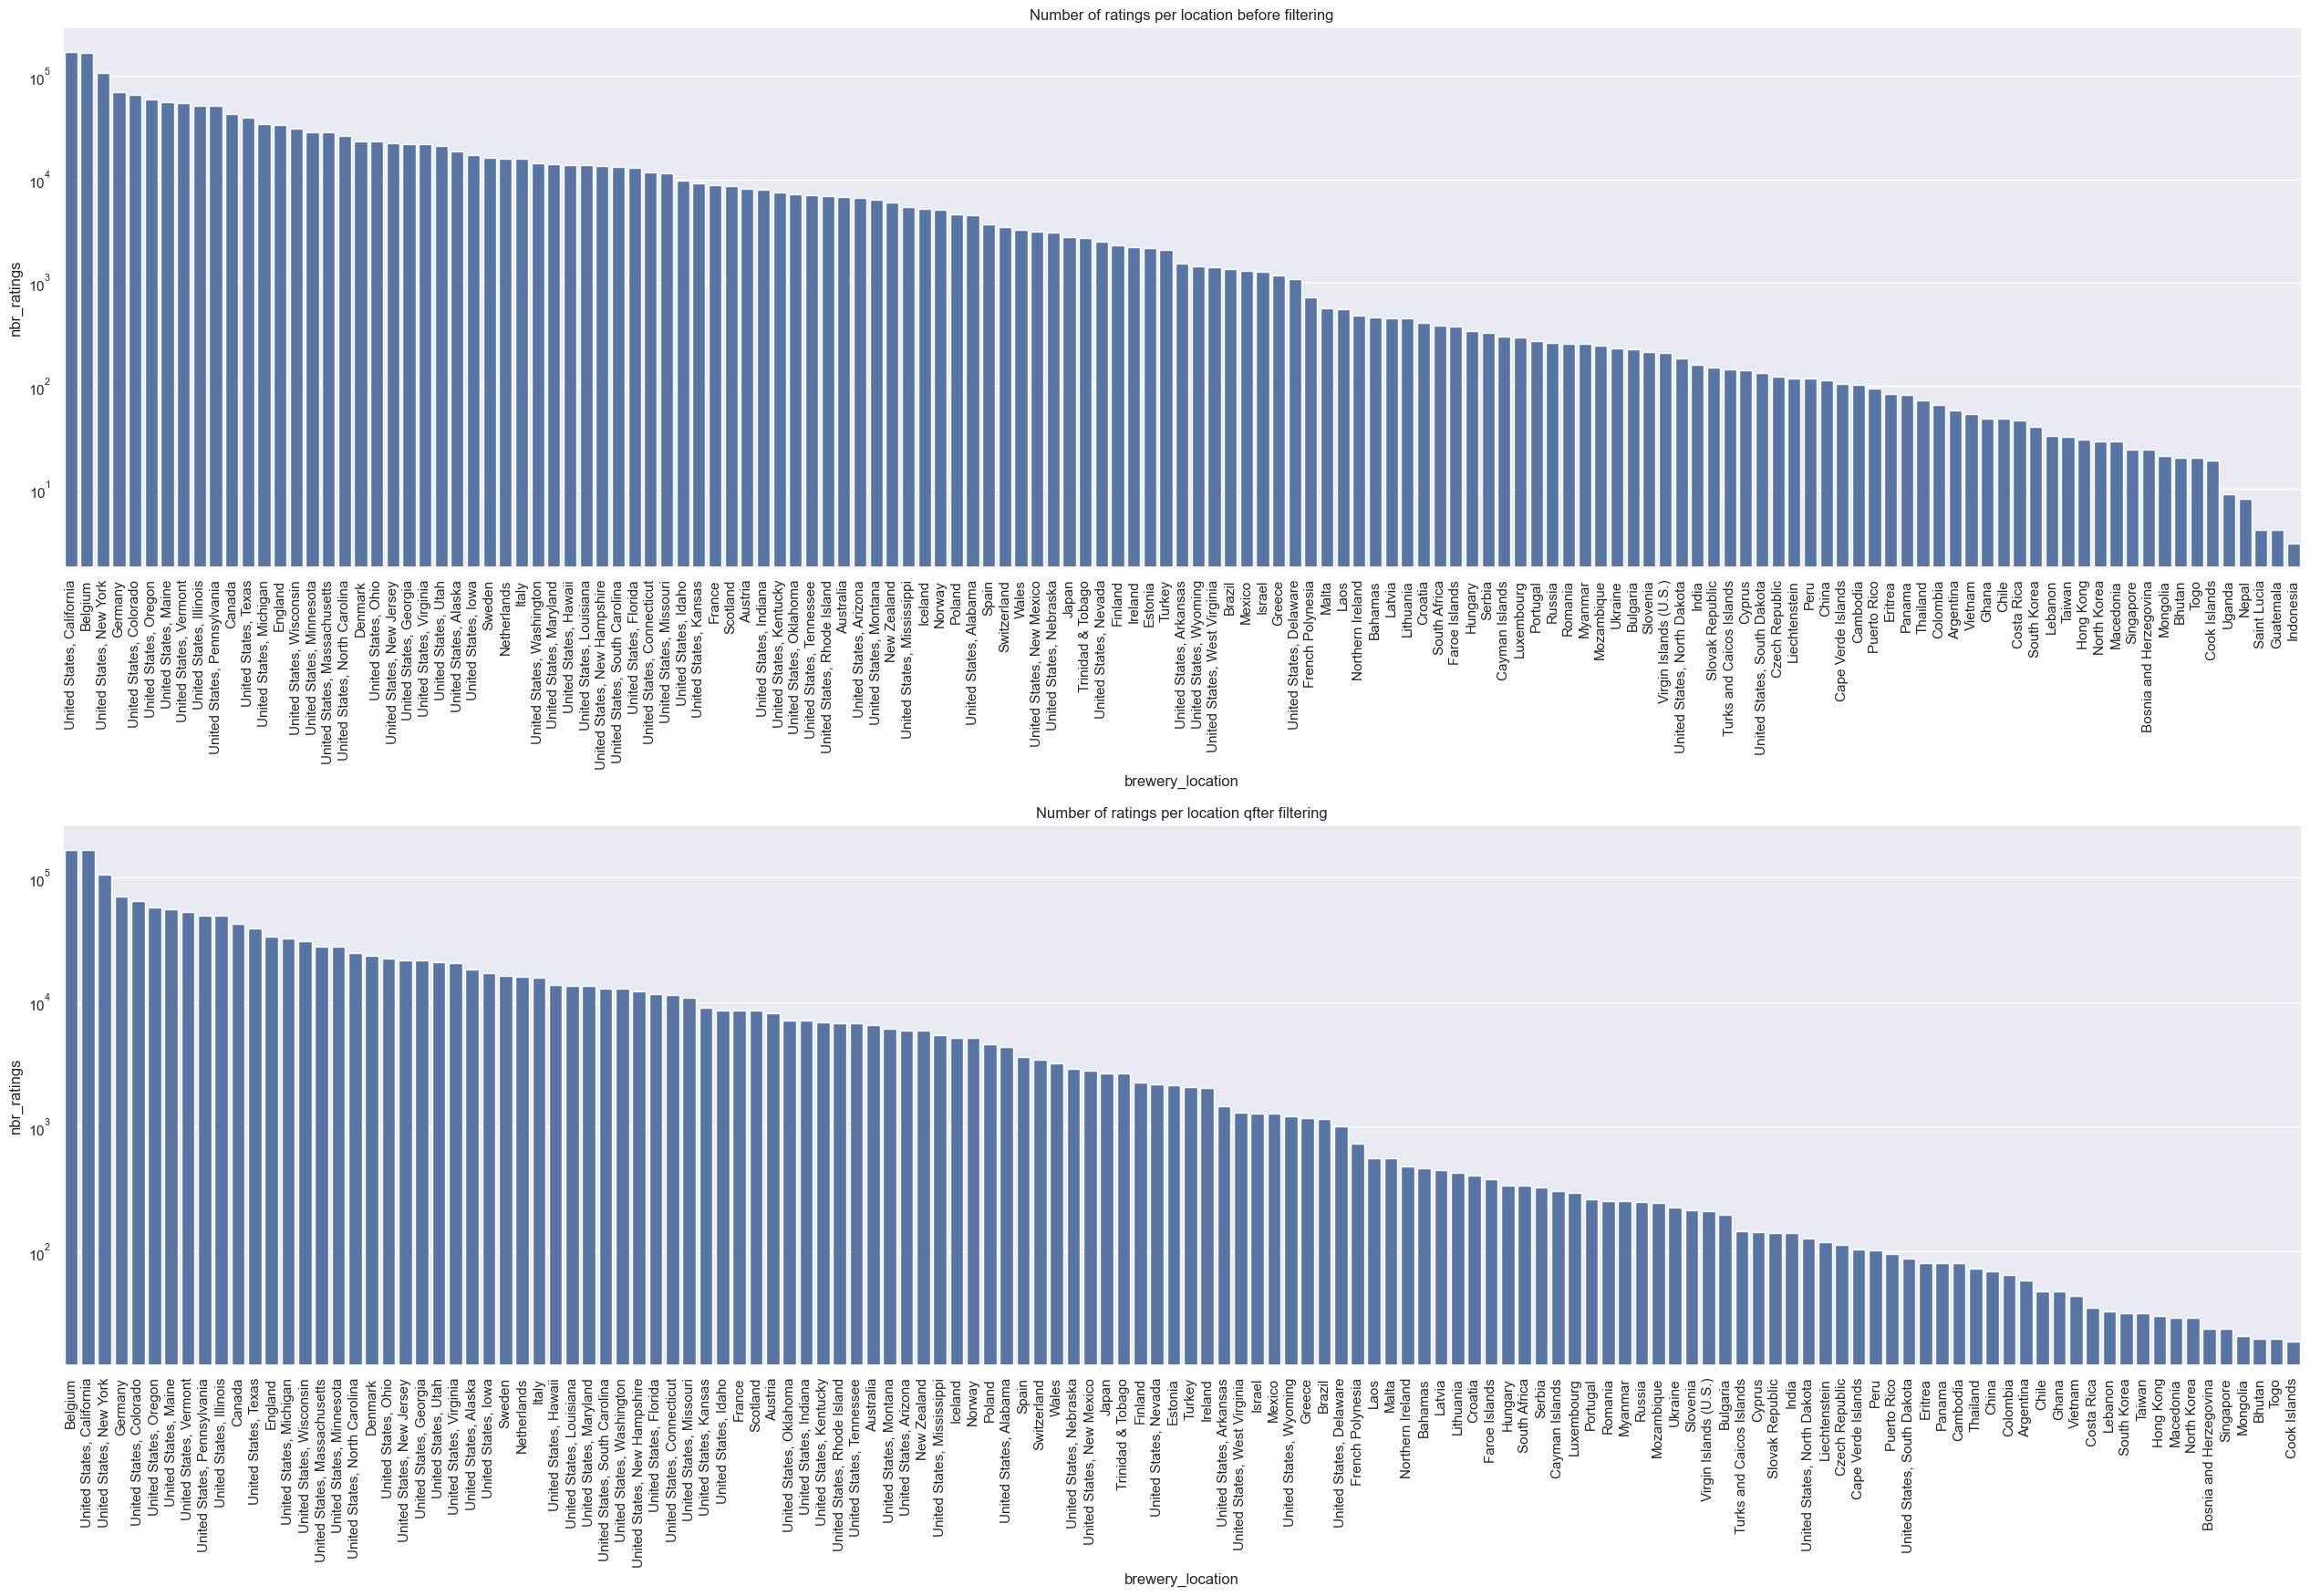

In [26]:
pd.set_option("display.max_columns", None)

world_ratings = reviews_df.copy()
world_ratings["nbr_ratings"] = world_ratings["nbr_ratings_rb"] + world_ratings["nbr_ratings_ba"]
#drop rows where user_location is NaN   
world_ratings = world_ratings.dropna()

#create df with only users from the us & remove duplicates
us_users_ratings = world_ratings[world_ratings["user_location"].str.contains("United States")]
us_users_ratings = us_users_ratings.T.drop_duplicates().T

#convert ratings from string to float
columns_compare = ["aroma", "appearance", "palate", "taste", "overall", "rating"]
us_users_ratings[columns_compare] = us_users_ratings[columns_compare].astype(float)

us_users_ratings["user_location"] = [name.replace("United States, ", "") for name in us_users_ratings["user_location"]]

#add climate column where climate is the climate of the state the user is from
us_users_ratings["climate"] = us_users_ratings["user_location"].map(states_climate["Climate"])

unique_beers = us_users_ratings[["beer_id", "nbr_ratings", "brewery_location"]].copy().drop_duplicates()
total_ratings = unique_beers["nbr_ratings"].sum()

unique_beers = unique_beers.groupby("brewery_location")["nbr_ratings"].sum().sort_values(ascending=False).reset_index()

fig, axs = plt.subplots(2,1,figsize=(30, 20))
fig.tight_layout(pad = 15.0)
sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nbr_ratings", data=unique_beers, orient="v", ax=axs[0])
axs[0].tick_params(axis="x", rotation=90)
axs[0].set_title("Number of ratings per location before filtering")
axs[0].set(yscale="log")

#only keep beers with more than 10 ratings
us_users_ratings = us_users_ratings[us_users_ratings["nbr_ratings"] > 10]

beers_left = us_users_ratings[["beer_id","nbr_ratings", "brewery_location"]].copy().drop_duplicates()

beers_left = beers_left.groupby("brewery_location")["nbr_ratings"].sum().sort_values(ascending=False).reset_index()

ratings_left = beers_left["nbr_ratings"].sum()
print(" Percentage of ratings left: ", ratings_left / total_ratings * 100, "%")

beers_left["Percentage of ratings"] = beers_left["nbr_ratings"] / beers_left["nbr_ratings"].sum() * 100

sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nbr_ratings", data=beers_left, orient="v", ax=axs[1])
axs[1].set_title("Number of ratings per location qfter filtering")
axs[1].tick_params(axis="x", rotation=90)
plt.yscale("log")

In [30]:
us_users_ratings["climate_scheme"] = us_users_ratings["climate"].map(climate_classifications["scheme"])
us_users_ratings["climate_precipitation"] = us_users_ratings["climate"].map(climate_classifications["seasonal_precipitation"])
us_users_ratings["climate_temperature"] = us_users_ratings["climate"].map(climate_classifications["heat_level"])

### Textual reviews

/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_15900/1065516929.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_users_txt["user_location"] = [name.replace("United States, ", "") for name in us_users_txt["user_location"]]


 Percentage of ratings left:  81.22244732746941 %


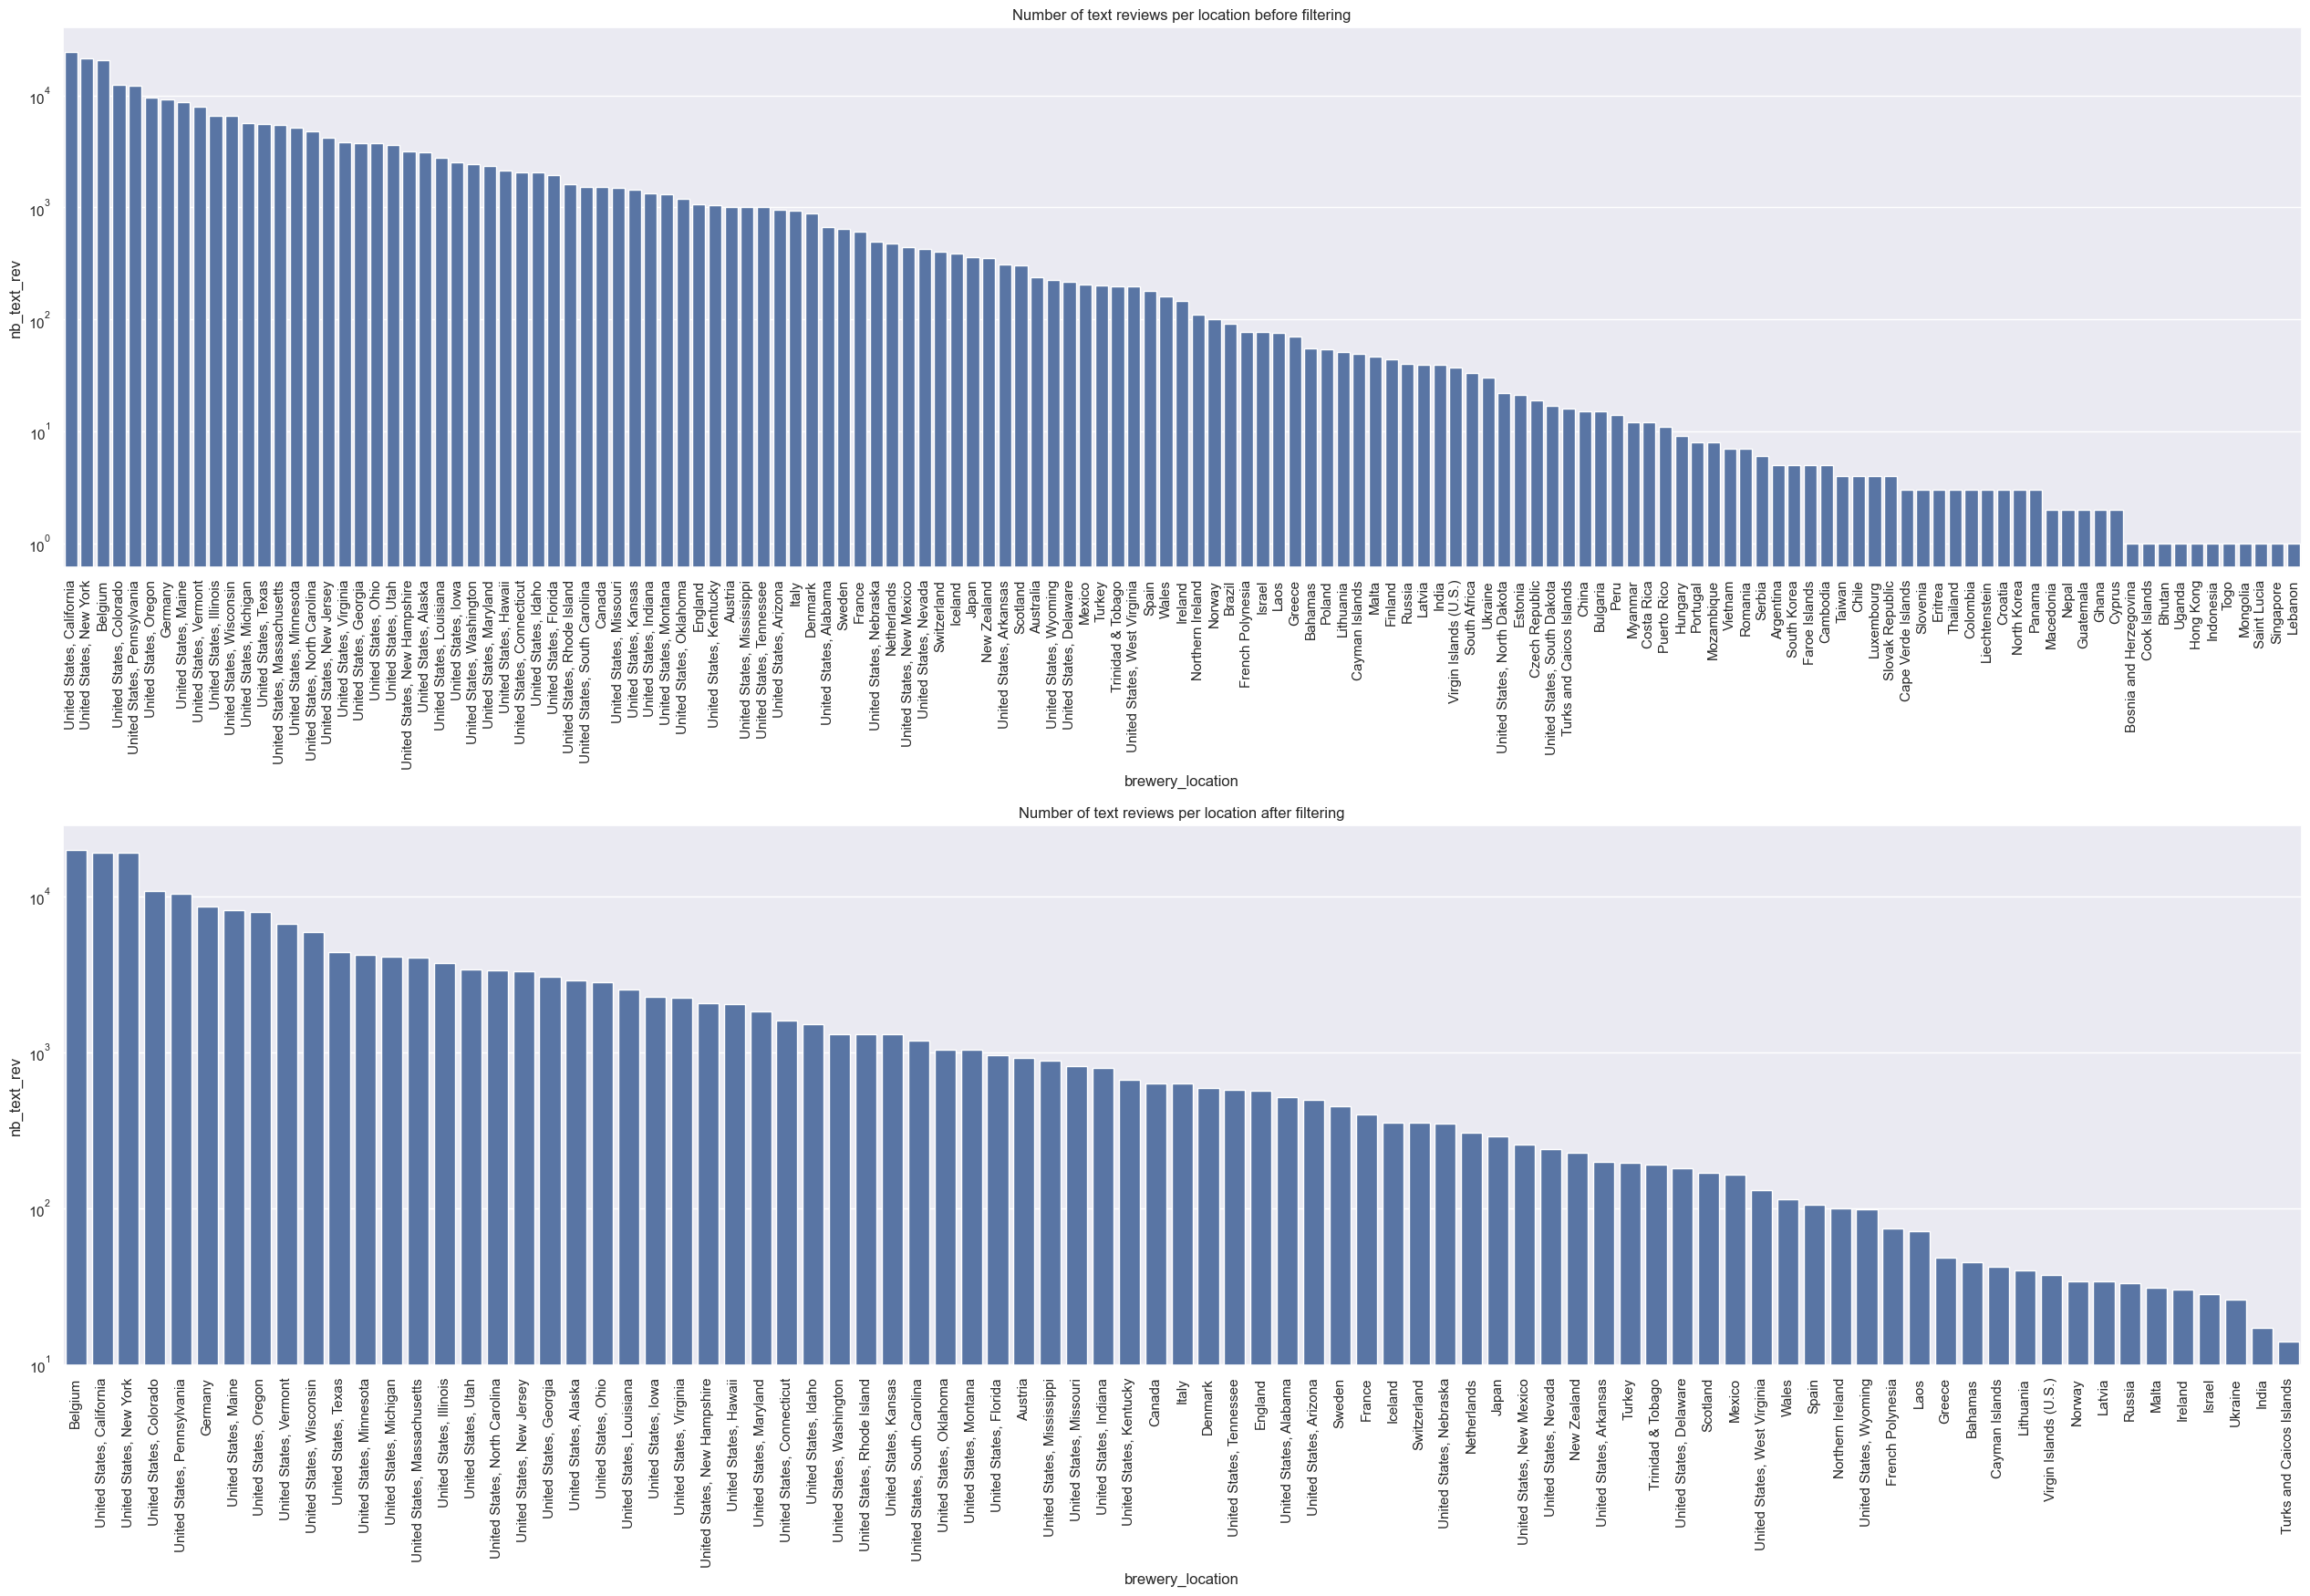

In [8]:
world_ratings = reviews_df.copy()
#drop rows where user_location is NaN   ?
world_ratings = world_ratings.dropna()

#create df with only users from the us
us_users_txt = world_ratings[world_ratings["user_location"].str.contains("United States")]

us_users_txt["user_location"] = [name.replace("United States, ", "") for name in us_users_txt["user_location"]]

#only reviews with text review
us_users_txt = us_users_txt[us_users_txt["text"]!="nan"]

#add climate column where climate is the climate of the state the user is from
us_users_txt["climate"] = us_users_txt["user_location"].map(states_climate["Climate"])

#count number of text reviews per beer

us_users_txt["nb_text_rev"] = us_users_txt.groupby("beer_id")["text"].transform("count")


unique_beers_txt = us_users_txt[["beer_id", "nb_text_rev", "brewery_location"]].copy().drop_duplicates()
total_ratings_txt = unique_beers_txt["nb_text_rev"].sum()

unique_beers_txt = unique_beers_txt.groupby("brewery_location")["nb_text_rev"].sum().sort_values(ascending=False).reset_index()

fig, axs = plt.subplots(2,1,figsize=(30, 20))
fig.tight_layout(pad = 15.0)
sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nb_text_rev", data=unique_beers_txt, orient="v", ax=axs[0])
axs[0].tick_params(axis="x", rotation=90)
axs[0].set_title("Number of text reviews per location before filtering")
axs[0].set(yscale="log")

#only keep beers with more than 10 ratings
us_users_txt = us_users_txt[us_users_txt["nb_text_rev"] > 10]

beers_left_txt = us_users_txt[["beer_id","nb_text_rev", "brewery_location"]].copy().drop_duplicates()

beers_left_txt = beers_left_txt.groupby("brewery_location")["nb_text_rev"].sum().sort_values(ascending=False).reset_index()

ratings_left_txt = beers_left_txt["nb_text_rev"].sum()
print(" Percentage of ratings left: ", ratings_left_txt / total_ratings_txt * 100, "%")

beers_left_txt["Percentage of ratings"] = beers_left_txt["nb_text_rev"] / beers_left_txt["nb_text_rev"].sum() * 100

sns.set(rc={"figure.figsize":(30, 10)})
sns.barplot(x="brewery_location", y="nb_text_rev", data=beers_left_txt, orient="v", ax=axs[1])
axs[1].set_title("Number of text reviews per location after filtering")
axs[1].tick_params(axis="x", rotation=90)
plt.yscale("log")


In [9]:
def plot_climate_stats(df, column, title, ax=None, symmetrical=False, categorical=False):
    """
    This function plots on a map of the United States the mean of the column passed as argument for each state depending on its climate.
    df should have a column "climate" and a column str(column) with the values to plot. Requires to call plt.show() after the function call.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data to plot
        column (str): Column to plot
        title (str): Title of the plot
        ax (matplotlib.axes.Axes, optional): Axes on which to plot. If None, a new figure and axes is created.
        symmetrical (bool, optional): If True, the colorbar is symmetrical around 0. If False, the colorbar is not symmetrical around 0.
        categorical (bool, optional): If True, the column is categorical. If False, the column is numerical.
    """
    
    us_map = gpd.read_file("data/Maps/US/cb_2018_us_state_500k.shp")
    states_climate = pd.read_csv("data/states_climate.csv")

    # Add climate column to us_map and the df
    us_map = us_map.merge(states_climate, left_on="NAME", right_on="State")
    
    us_map = us_map.merge(df, left_on="Climate", right_on="climate")
    
    # For display purposes, move Alaska and Hawaii to the East
    alaska = us_map[us_map["NAME"] == "Alaska"].geometry
    hawaii = us_map[us_map["NAME"] == "Hawaii"].geometry

    alaska = alaska.translate(xoff=40)
    hawaii = hawaii.translate(xoff=40)

    us_map_shifted = us_map.copy()
    us_map_shifted.loc[us_map_shifted["NAME"] == "Alaska", "geometry"] = alaska
    us_map_shifted.loc[us_map_shifted["NAME"] == "Hawaii", "geometry"] = hawaii
    
    # Plot the map
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,7))
    us_map_shifted.boundary.plot(ax=ax, linewidth=1, color="black")
    
    if symmetrical:
        cmap_name = "RdBu_r"
    elif categorical:
        cmap_name = "tab10"
    else:
        cmap_name = "YlOrRd"
        
    
    us_map_shifted.plot(column=column, cmap=cmap_name, ax=ax, legend=True, missing_kwds={"color": "lightgrey", "label": "Missing values"})
    ax.set_title(title)
    ax.set_axis_off()
    ax.set_xlim(-140, -60)

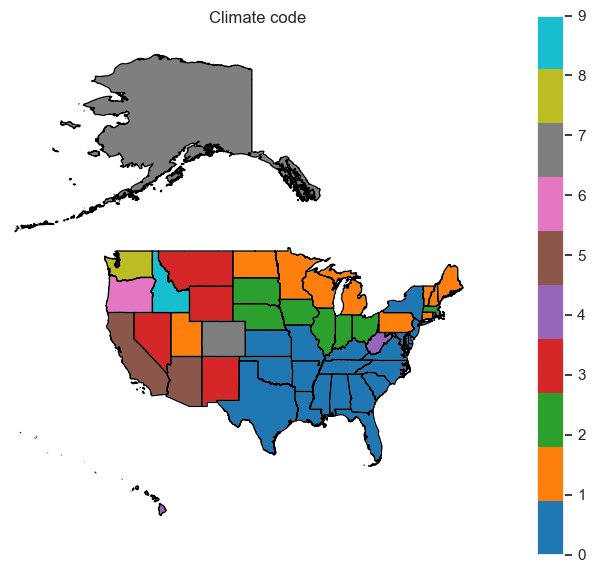

In [10]:
climate_df = pd.DataFrame(columns=["climate", "climate_code"])
climate_df["climate"] = states_climate["Climate"].unique()
climate_df["climate_code"] = range(len(climate_df))

plot_climate_stats(climate_df, "climate_code", "Climate code", categorical=True)

Seasonal precipitation:
['without dry season' 'with dry season']
Heat level:
['hot summer' 'warm summer' 'cold summer']


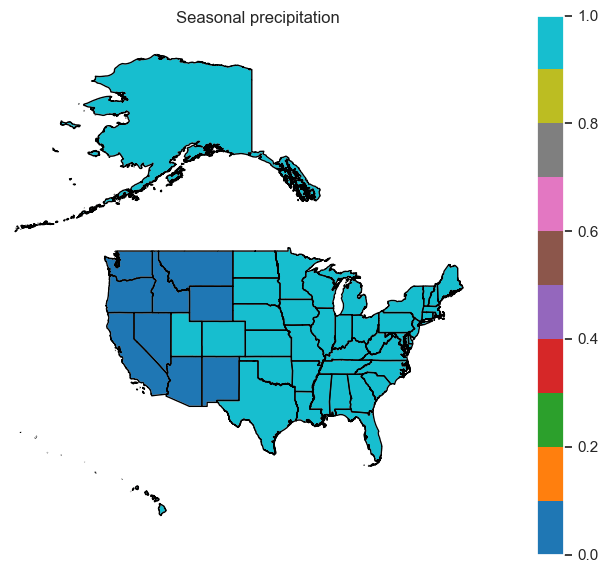

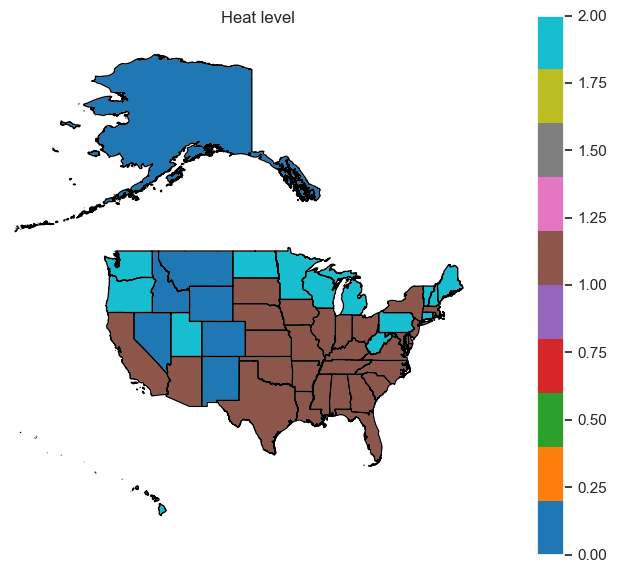

In [32]:
# Plot the 3 level of climate classification

# First turn "scheme", "seasonal_precipitation" and "heat_level" columns into int ids
climate_classifications_plot = climate_classifications.copy()
climate_classifications_plot["scheme"] = climate_classifications_plot["scheme"].astype("category").cat.codes
climate_classifications_plot["seasonal_precipitation"] = climate_classifications_plot["seasonal_precipitation"].astype("category").cat.codes
climate_classifications_plot["heat_level"] = climate_classifications_plot["heat_level"].astype("category").cat.codes

print("Seasonal precipitation:")
print(climate_classifications["seasonal_precipitation"].unique())
plot_climate_stats(climate_classifications_plot, "seasonal_precipitation", "Seasonal precipitation", categorical=True)

print("Heat level:")
print(climate_classifications["heat_level"].unique())
plot_climate_stats(climate_classifications_plot, "heat_level", "Heat level", categorical=True)

## Add the column *General Style*

In [71]:
# reimport edited file with the corresponding beer types
mapping_df = pd.DataFrame(pd.read_excel("beer_style_edited.xlsx")) 
print("There are {} different general beer types".format(len(set(mapping_df['general_style']))))

# extract all general beer types
general_beer_types = list(set(mapping_df['general_style']))
print(general_beer_types)

# add a column to the us_users_ratings dataframe with the corresponding general beer type
us_users_ratings = pd.merge(us_users_ratings, mapping_df, on='style', how='left')
us_users_ratings.head()

There are 10 different general beer types
['Brown Ale', 'IPA', 'Porter', 'Sour Ale', 'Wheat beer', 'Blonde Ale', 'Stout', 'Scottish Ale ', 'Lager', 'Pale Ale']


,beer_id,style,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text,review,abv,beer_avg_rating_ba,beer_name,brewery_id_ba,nbr_ratings_ba,beer_avg_rating_rb,beer_id_rb,brewery_id_rb,nbr_ratings_rb,beer_avg_rating_ba_rb,brewery_location,brewery_name,brewery_nbr_beers_ba,brewery_nbr_beers_rb,user_location,user_nbr_ratings,nbr_ratings,climate,climate_scheme,climate_precipitation,climate_temperature,general_style
0,19827,English Pale Ale,1360753200,brewdude1982,brewdude1982.691169,4.25,4.50,3.25,3.75,3.75,3.91,This was a 12 oz bottle poured into a snifter....,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,264.0,164,Cfa,Temperate,without dry season,hot summer,Pale Ale
1,19827,English Pale Ale,1357729200,AgentMunky,agentmunky.409755,4.00,3.75,3.50,3.50,3.75,3.64,Poured from a 12 ounce bottle into a pilsner g...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,New York,2314.0,164,Cfa,Temperate,without dry season,hot summer,Pale Ale
2,19827,English Pale Ale,1353150000,ferrari29,ferrari29.320392,3.00,3.50,2.50,2.50,2.50,2.77,Beer poured from bottle into a Nonic shaped pi...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Illinois,585.0,164,Dfa,Continental,without dry season,hot summer,Pale Ale
3,19827,English Pale Ale,1342260000,OtherShoe2,othershoe2.233642,4.00,3.50,4.00,3.50,4.00,3.68,Pours a rich brownish red with some chill haze...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,Massachusetts,1315.0,164,Dfa,Continental,without dry season,hot summer,Pale Ale
4,19827,English Pale Ale,1335607200,brentk56,brentk56.6284,4.50,3.00,3.50,2.50,2.50,2.84,Appearance: These Strangford Lough beers pour ...,True,4.8,3.439867,Legbiter,10093,75,2.923596,37923,4959,89,3.159695,Northern Ireland,Strangford Lough Brewing Company Ltd,5,5,North Carolina,6306.0,164,Cfa,Temperate,without dry season,hot summer,Pale Ale


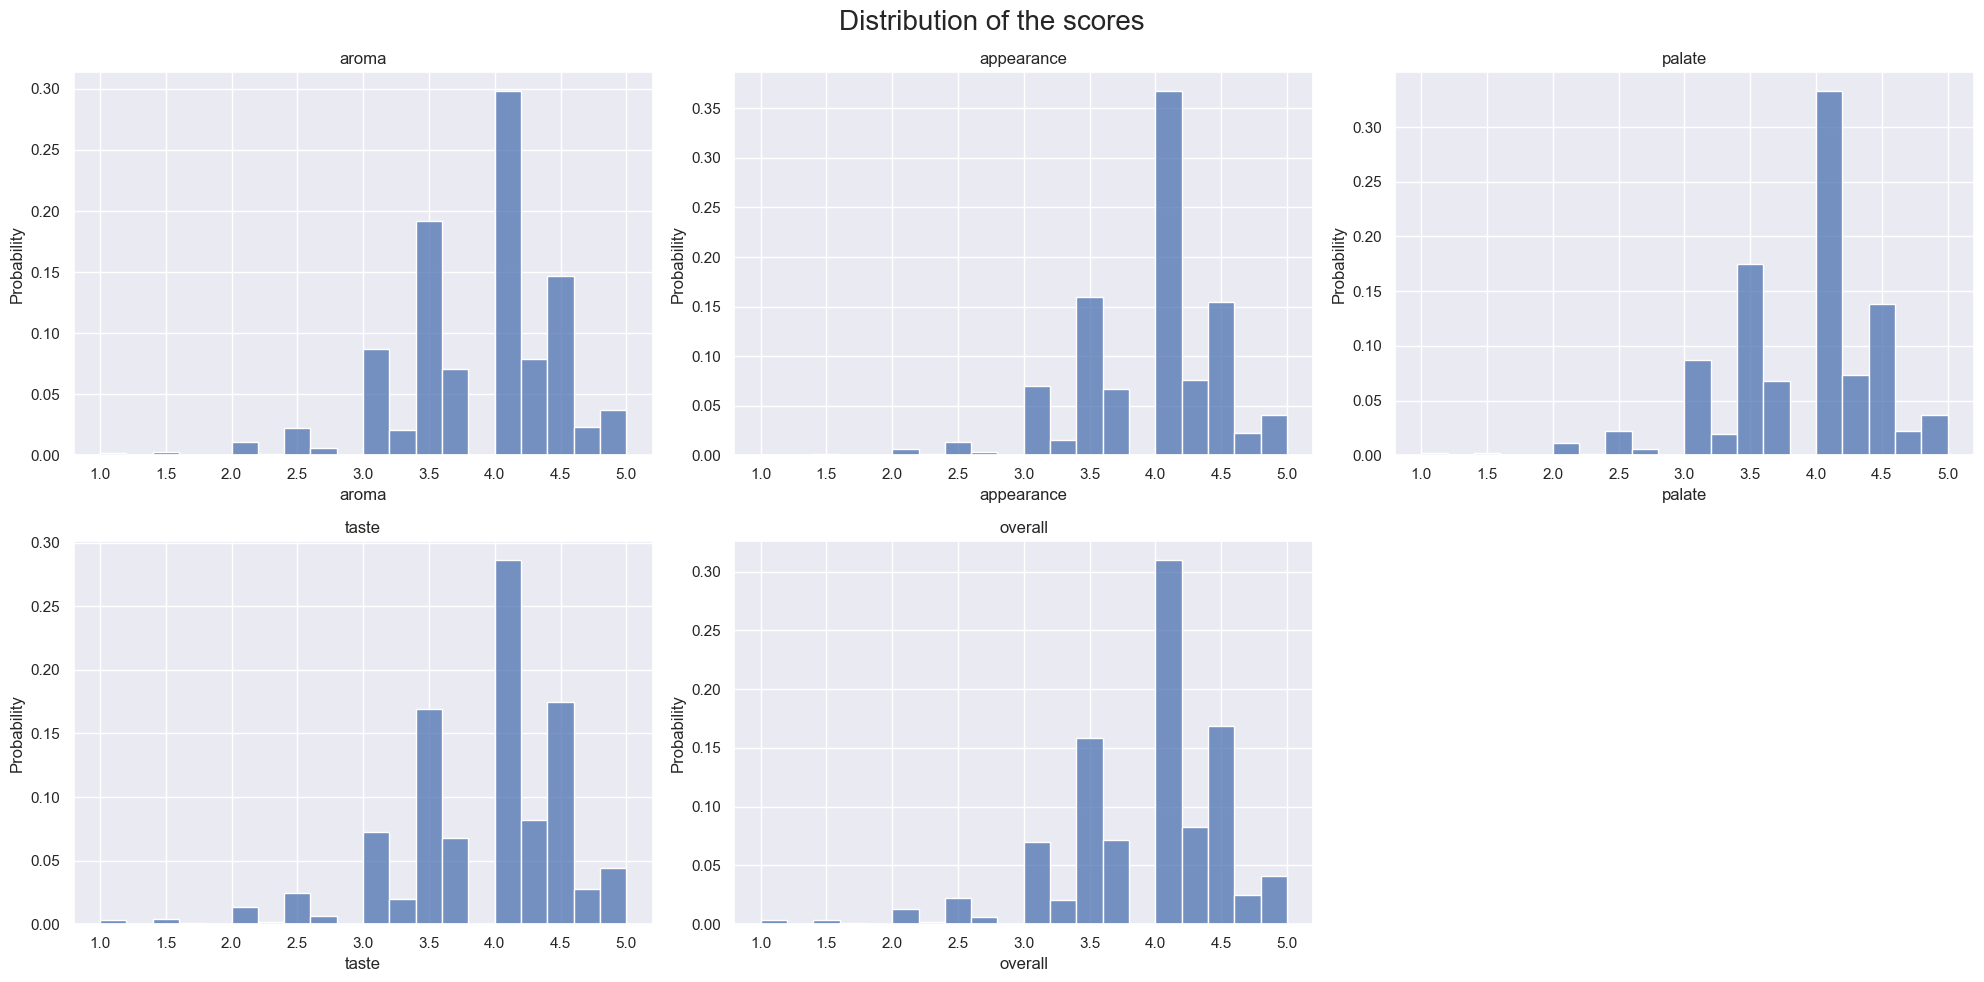

In [81]:
# Compute for each main score the max and min score
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]

# Plot the distribution of the scores
fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, score in enumerate(scores_to_compare):
    ax = axs[i // 3][i % 3]
    sns.histplot(us_users_ratings[score], ax=ax, stat="probability", bins=20)
    ax.set_title(score)
    
axs[1][2].set_visible(False)
    
fig.suptitle("Distribution of the scores", fontsize=20)
plt.tight_layout()
plt.show()


In [78]:
# For each score find 5th and 95th percentile
percentile_5 = us_users_ratings[scores_to_compare].quantile(0.05)
percentile_95 = us_users_ratings[scores_to_compare].quantile(0.95)

# Print the diff between 5th and 95th percentile
for score in scores_to_compare:
    print("For {} the diff between 5th and 95th percentile is {}".format(score, percentile_95[score] - percentile_5[score]))

For aroma the diff between 5th and 95th percentile is 1.75
For appearance the diff between 5th and 95th percentile is 1.75
For palate the diff between 5th and 95th percentile is 1.75
For taste the diff between 5th and 95th percentile is 2.0
For overall the diff between 5th and 95th percentile is 2.0


## 2) First analysis : how beers from one country are rated (reviewed)

We first want to look at how beers from a given country are perceived by users. We start from the full dataframe with all the reviews.

### Data cleaning

Let's first look at distribution of number of reviews

In [93]:
micro_average_ratings = us_users_ratings[columns_compare].mean().sort_values(ascending=False).reset_index()

display(micro_average_ratings)

# Let's compute statistics for each climate
climate_average_ratings = us_users_ratings.groupby("climate")[columns_compare].mean().sort_values(by="overall", ascending=False).reset_index()
climate_average_ratings.set_index("climate", inplace=True)
macro_average_ratings = climate_average_ratings.mean().sort_values(ascending=False).reset_index()

display(macro_average_ratings)

,index,0
0,appearance,3.930901
1,overall,3.890745
2,taste,3.884031
3,rating,3.878382
4,palate,3.853295
5,aroma,3.851912


,index,0
0,appearance,3.905484
1,overall,3.854531
2,taste,3.848403
3,rating,3.844435
4,aroma,3.821968
5,palate,3.815506


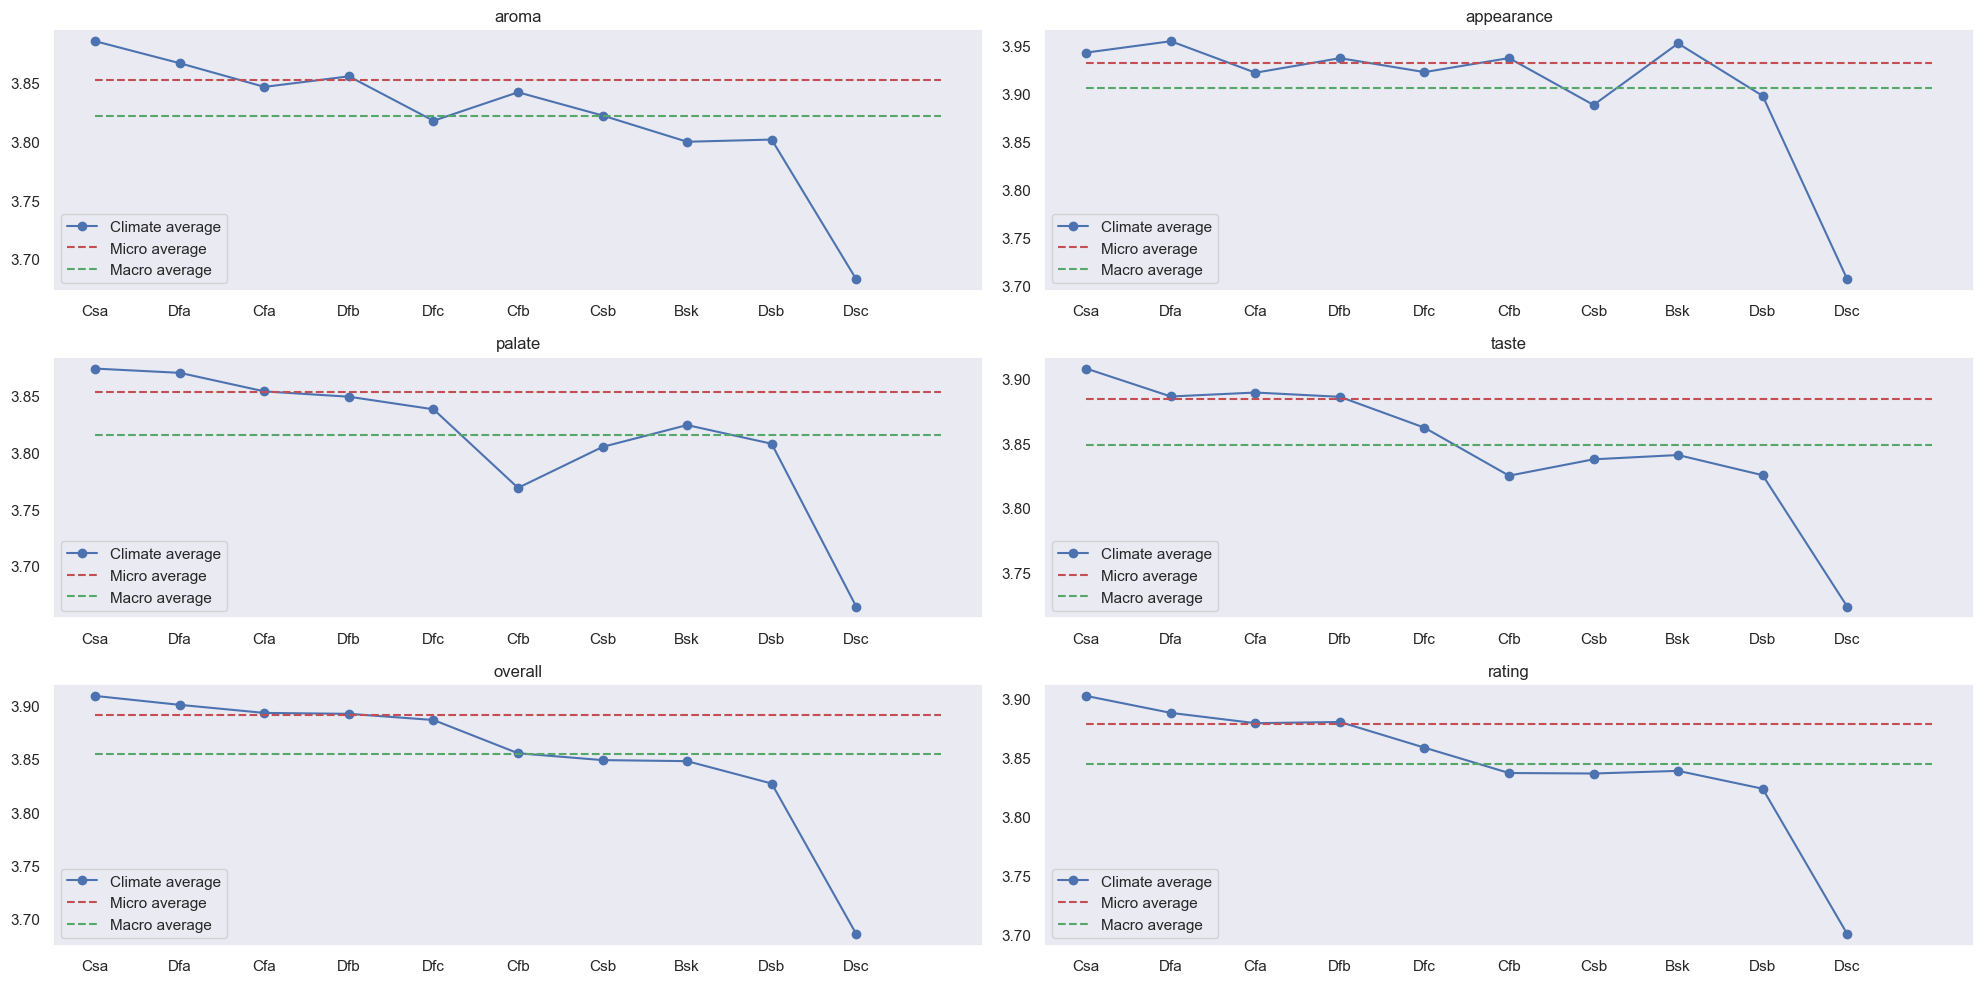

In [94]:
# Plot the different mean as a function of the climate
num_scores = len(columns_compare)

fig, axs = plt.subplots(num_scores//2, 2, figsize=(20, 10))

for i in range(num_scores//2):
    axs[i, 0].plot(climate_average_ratings.iloc[:, 2*i], "o-", label="Climate average")
    micro_average_value = micro_average_ratings[micro_average_ratings["index"] == columns_compare[2*i]][0].values[0]
    macro_average_value = macro_average_ratings[macro_average_ratings["index"] == columns_compare[2*i]][0].values[0]
    axs[i, 0].plot([0, len(climate_average_ratings)], [micro_average_value, micro_average_value], "r--", label="Micro average")
    axs[i, 0].plot([0, len(climate_average_ratings)], [macro_average_value, macro_average_value], "g--", label="Macro average")
    axs[i, 0].set_title(columns_compare[2*i])
    axs[i, 0].set_xticks(range(len(climate_average_ratings)))
    axs[i, 0].legend()
    axs[i, 0].grid()

    axs[i, 1].plot(climate_average_ratings.iloc[:, 2*i+1], "o-", label="Climate average")
    micro_average_value = micro_average_ratings[micro_average_ratings["index"] == columns_compare[2*i+1]][0].values[0]
    macro_average_value = macro_average_ratings[macro_average_ratings["index"] == columns_compare[2*i+1]][0].values[0]
    axs[i, 1].plot([0, len(climate_average_ratings)], [micro_average_value, micro_average_value], "r--", label="Micro average")
    axs[i, 1].plot([0, len(climate_average_ratings)], [macro_average_value, macro_average_value], "g--", label="Macro average")
    axs[i, 1].set_title(columns_compare[2*i+1])
    axs[i, 1].set_xticks(range(len(climate_average_ratings)))
    axs[i, 1].legend()
    axs[i, 1].grid()

plt.tight_layout()
plt.show()

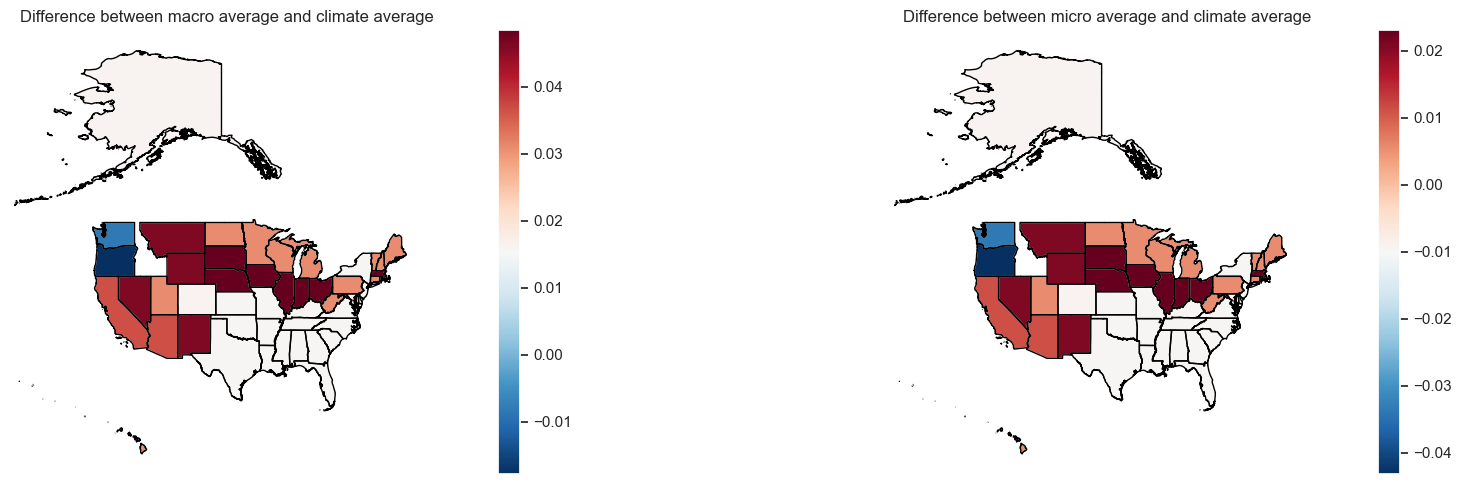

In [95]:
climate_appearance = climate_average_ratings["appearance"].reset_index()

# Drop Dsc climate for testing as it seems like a big outlier
climate_appearance = climate_appearance[climate_appearance["climate"] != "Dsc"]

climate_appearance["diff_macro"] = climate_appearance["appearance"] - macro_average_ratings[macro_average_ratings["index"] == "appearance"][0].values[0]
climate_appearance["diff_micro"] = climate_appearance["appearance"] - micro_average_ratings[micro_average_ratings["index"] == "appearance"][0].values[0]

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

plot_climate_stats(climate_appearance, "diff_macro", "Difference between macro average and climate average", ax=axs[0], symmetrical=True)
plot_climate_stats(climate_appearance, "diff_micro", "Difference between micro average and climate average", ax=axs[1], symmetrical=True)

plt.tight_layout()
plt.show()

Let's go in more in-depth analysis of the climate distribution

In [21]:
# First we can print the number of reviews per climate
print("Number of reviews per climate:")
display(us_users_ratings["climate"].value_counts())

Number of reviews per climate:


climate
Cfa    85617
Dfb    50644
Dfa    44947
Csa    22066
Dsb     8202
Dfc     7704
Csb     4708
Bsk     2150
Cfb     1148
Dsc     1008
Name: count, dtype: int64

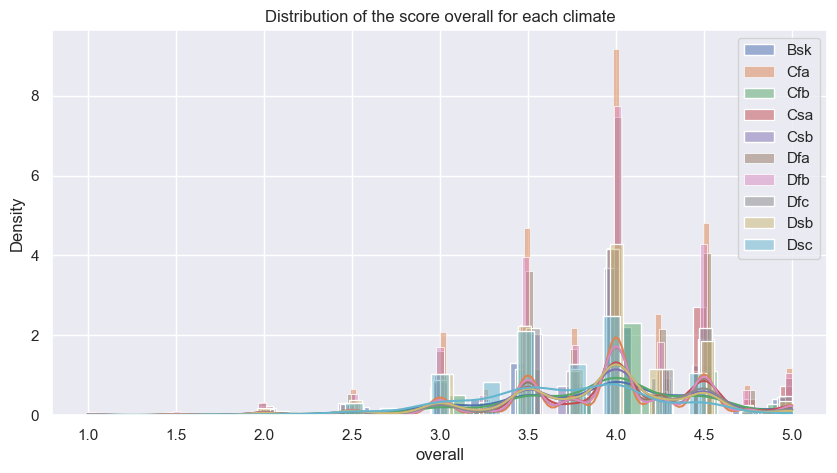

In [22]:
# For one chosen score, plot the distribution of the score for each climate
score = "overall"

# Get the data
data_to_plot = us_users_ratings[["climate", score]].copy()
data_to_plot = data_to_plot.groupby("climate")[score].apply(list).reset_index()

# Plot the data
box_plot = False
if box_plot:
    fig, ax = plt.subplots(figsize=(20, 5))
    ax.boxplot(data_to_plot[score])
    ax.set_xticklabels(data_to_plot["climate"])
    ax.set_ylabel(score)
    ax.set_title("Distribution of the score " + score + " for each climate")
else:
    # Use superimposed histograms
    fig, ax = plt.subplots(figsize=(10, 5))
    for i in range(len(data_to_plot)):
        sns.histplot(data_to_plot[score][i], ax=ax, label=data_to_plot["climate"][i], kde=True, stat="density")
    ax.set_xlabel(score)
    ax.set_ylabel("Density")
    ax.set_title("Distribution of the score " + score + " for each climate")
    ax.legend()
    
    
plt.show()

In [49]:
# Perform a chi2 test to see if the distribution of the score is the same for each climate
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]

for score in scores_to_compare:
    contingency_table = pd.crosstab(us_users_ratings["climate"], us_users_ratings[score])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print("Score:", score, "; p-value:", p)

Score: aroma ; p-value: 8.714104765750106e-243
Score: appearance ; p-value: 8.295401714065448e-276
Score: palate ; p-value: 3.948172528328264e-235
Score: taste ; p-value: 1.1338091731727309e-218
Score: overall ; p-value: 6.97769800810602e-209


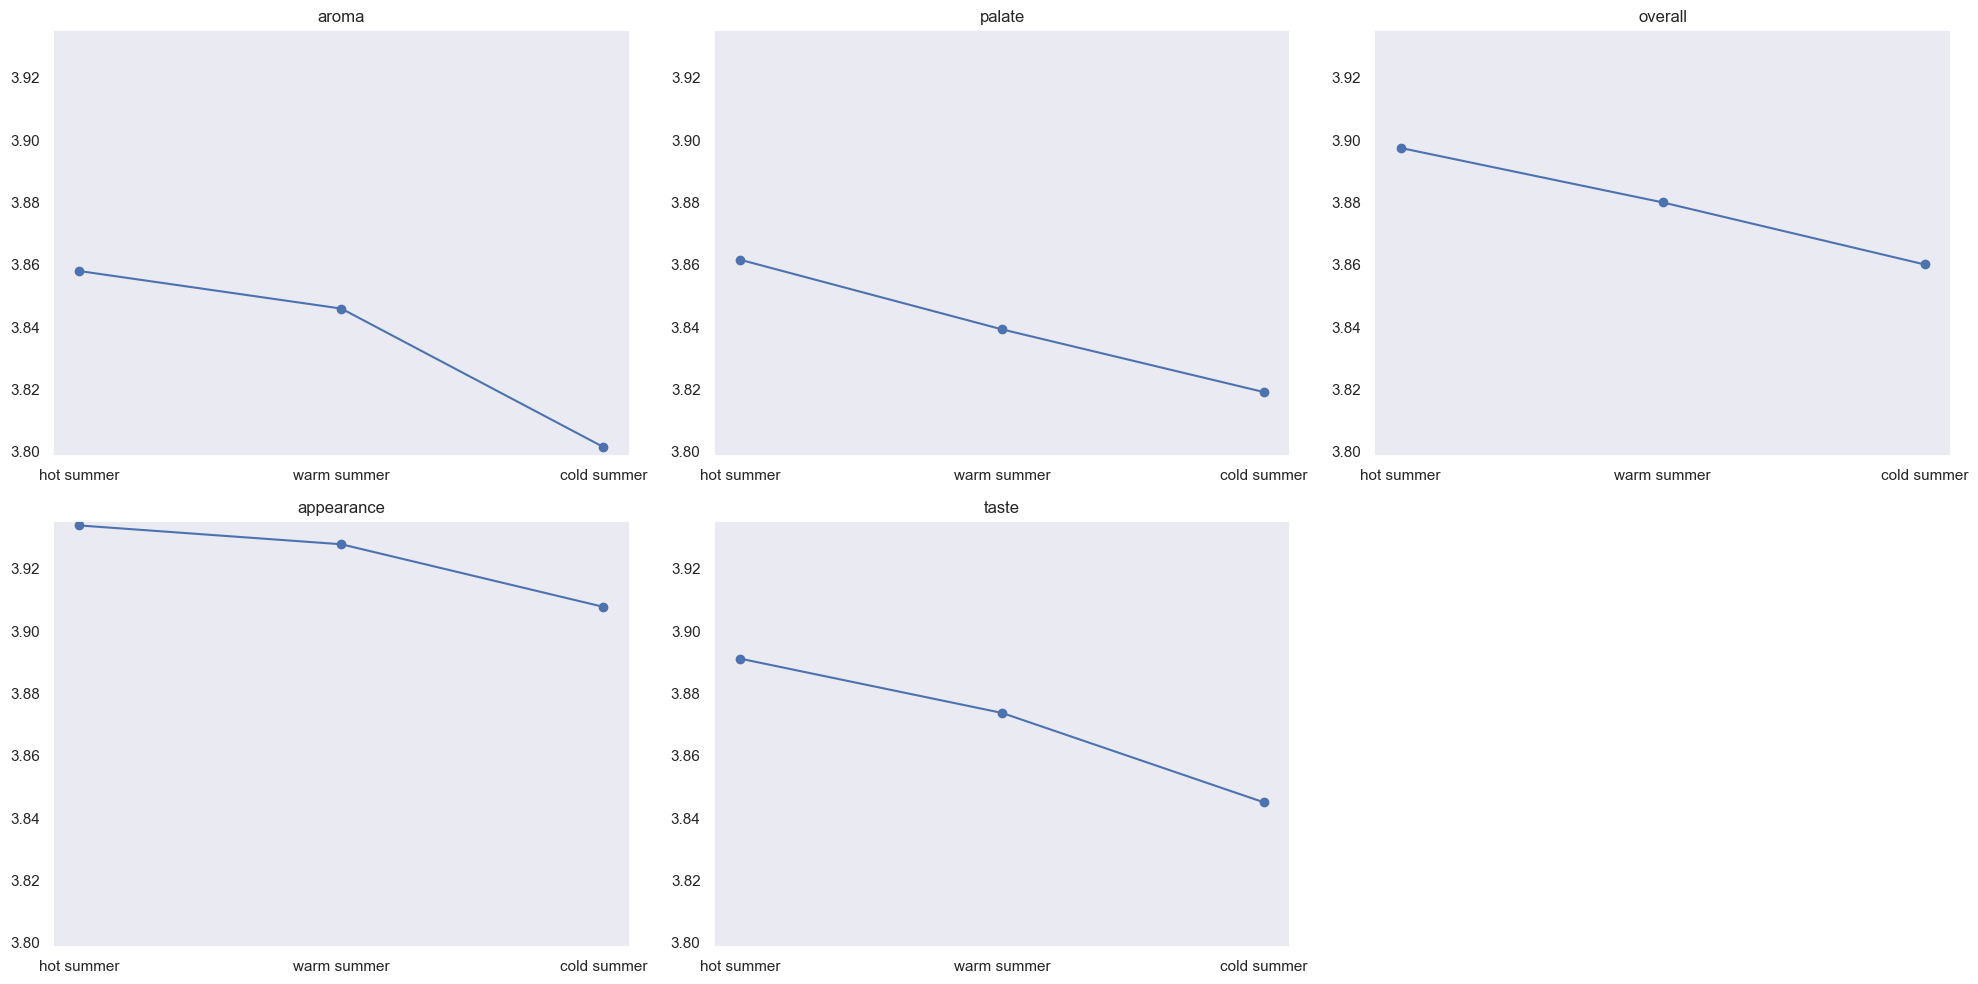

In [50]:
# Now let's analyze but using the climate_temperature column
climate_temperature_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_t in climate_classifications["heat_level"].unique():
    climate_temperature_dfs[climate_t] = us_users_ratings[us_users_ratings["climate_temperature"] == climate_t]
    
    for score in scores_to_compare:
        averages_scores[(climate_t, score)] = climate_temperature_dfs[climate_t][score].mean()
        
# Plot the average overall score for each climate
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

max_y_scale = 0
min_y_scale = 6

for i, score in enumerate(scores_to_compare):
    ax[i%2, i//2].plot([averages_scores[(climate_t, score)] for climate_t in climate_classifications["heat_level"].unique()], "o-")
    ax[i%2, i//2].set_xticks(range(len(climate_classifications["heat_level"].unique())))
    ax[i%2, i//2].set_xticklabels(climate_classifications["heat_level"].unique())
    ax[i%2, i//2].set_title(score)
    ax[i%2, i//2].grid()
    
    if ax[i%2, i//2].get_ylim()[1] > max_y_scale:
        max_y_scale = ax[i%2, i//2].get_ylim()[1]
    if ax[i%2, i//2].get_ylim()[0] < min_y_scale:
        min_y_scale = ax[i%2, i//2].get_ylim()[0]
        
        
for i, score in enumerate(scores_to_compare):
    ax[i%2, i//2].set_ylim(min_y_scale, max_y_scale)

ax[1, 2].axis("off")    
plt.tight_layout()
plt.show()


In [51]:
# chi2 test for the climate_temperature column
for score in scores_to_compare:
    contingency_table = pd.crosstab(us_users_ratings["climate_temperature"], us_users_ratings[score])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print("Score:", score, "; p-value:", p)

Score: aroma ; p-value: 1.6538031801189878e-58
Score: appearance ; p-value: 2.385886424968241e-77
Score: palate ; p-value: 5.200940341472633e-57
Score: taste ; p-value: 1.7829084242418892e-51
Score: overall ; p-value: 1.1213744270118151e-40


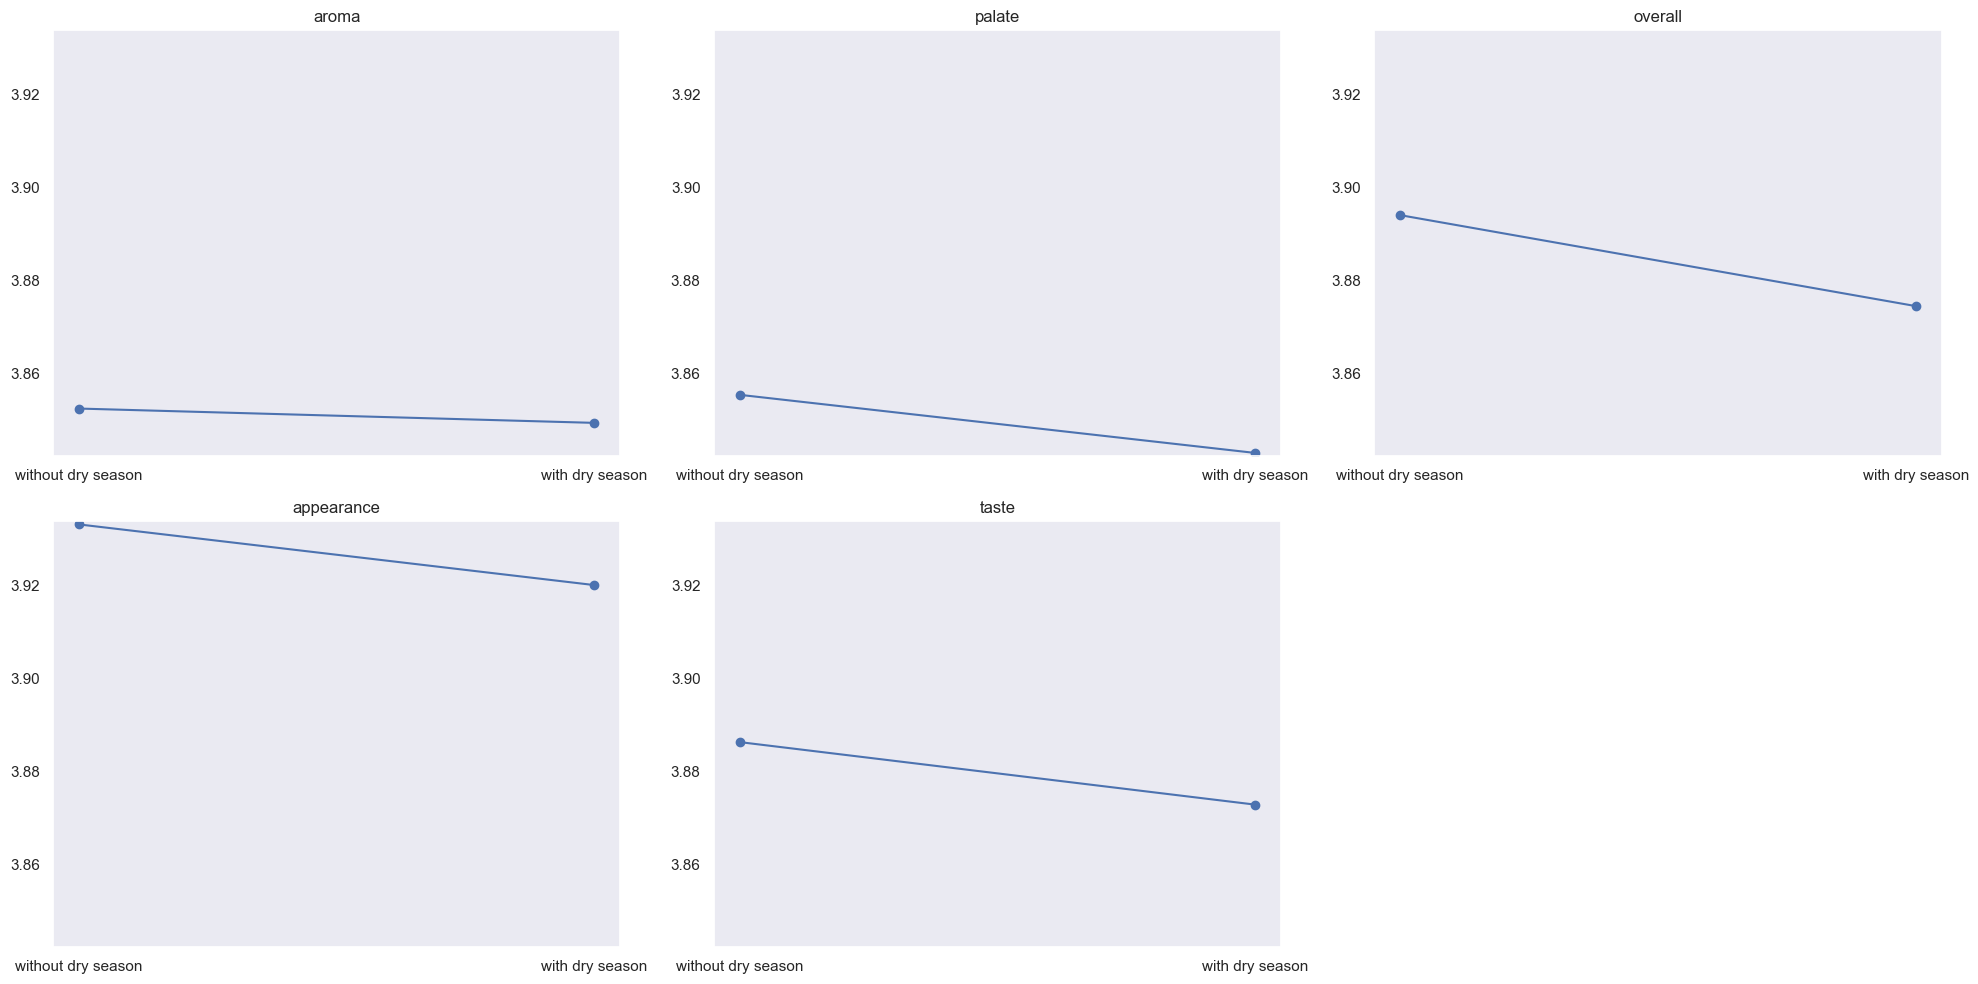

In [64]:
# Now let's analyze but using the climate_precipitation column
climate_precipitation_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_p in climate_classifications["seasonal_precipitation"].unique():
    climate_precipitation_dfs[climate_p] = us_users_ratings[us_users_ratings["climate_precipitation"] == climate_p]
    
    for score in scores_to_compare:
        averages_scores[(climate_p, score)] = climate_precipitation_dfs[climate_p][score].mean()
        
# Plot the average overall score for each climate
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

max_y_scale = 0
min_y_scale = 6

for i, score in enumerate(scores_to_compare):
    ax[i%2, i//2].plot([averages_scores[(climate_p, score)] for climate_p in climate_classifications["seasonal_precipitation"].unique()], "o-")
    ax[i%2, i//2].set_xticks(range(len(climate_classifications["seasonal_precipitation"].unique())))
    ax[i%2, i//2].set_xticklabels(climate_classifications["seasonal_precipitation"].unique())
    ax[i%2, i//2].set_title(score)
    ax[i%2, i//2].grid()
    
    if ax[i%2, i//2].get_ylim()[1] > max_y_scale:
        max_y_scale = ax[i%2, i//2].get_ylim()[1]
    if ax[i%2, i//2].get_ylim()[0] < min_y_scale:
        min_y_scale = ax[i%2, i//2].get_ylim()[0]
        
        
for i, score in enumerate(scores_to_compare):
    ax[i%2, i//2].set_ylim(min_y_scale, max_y_scale)

ax[1, 2].axis("off")    
plt.tight_layout()
plt.show()


In [53]:
for score in scores_to_compare:
    contingency_table = pd.crosstab(us_users_ratings["climate_precipitation"], us_users_ratings[score])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print("Score:", score, "; p-value:", p)

Score: aroma ; p-value: 6.090189634967279e-15
Score: appearance ; p-value: 4.464383914180567e-19
Score: palate ; p-value: 1.154161415397264e-09
Score: taste ; p-value: 3.243073175680188e-20
Score: overall ; p-value: 8.101141738872513e-20


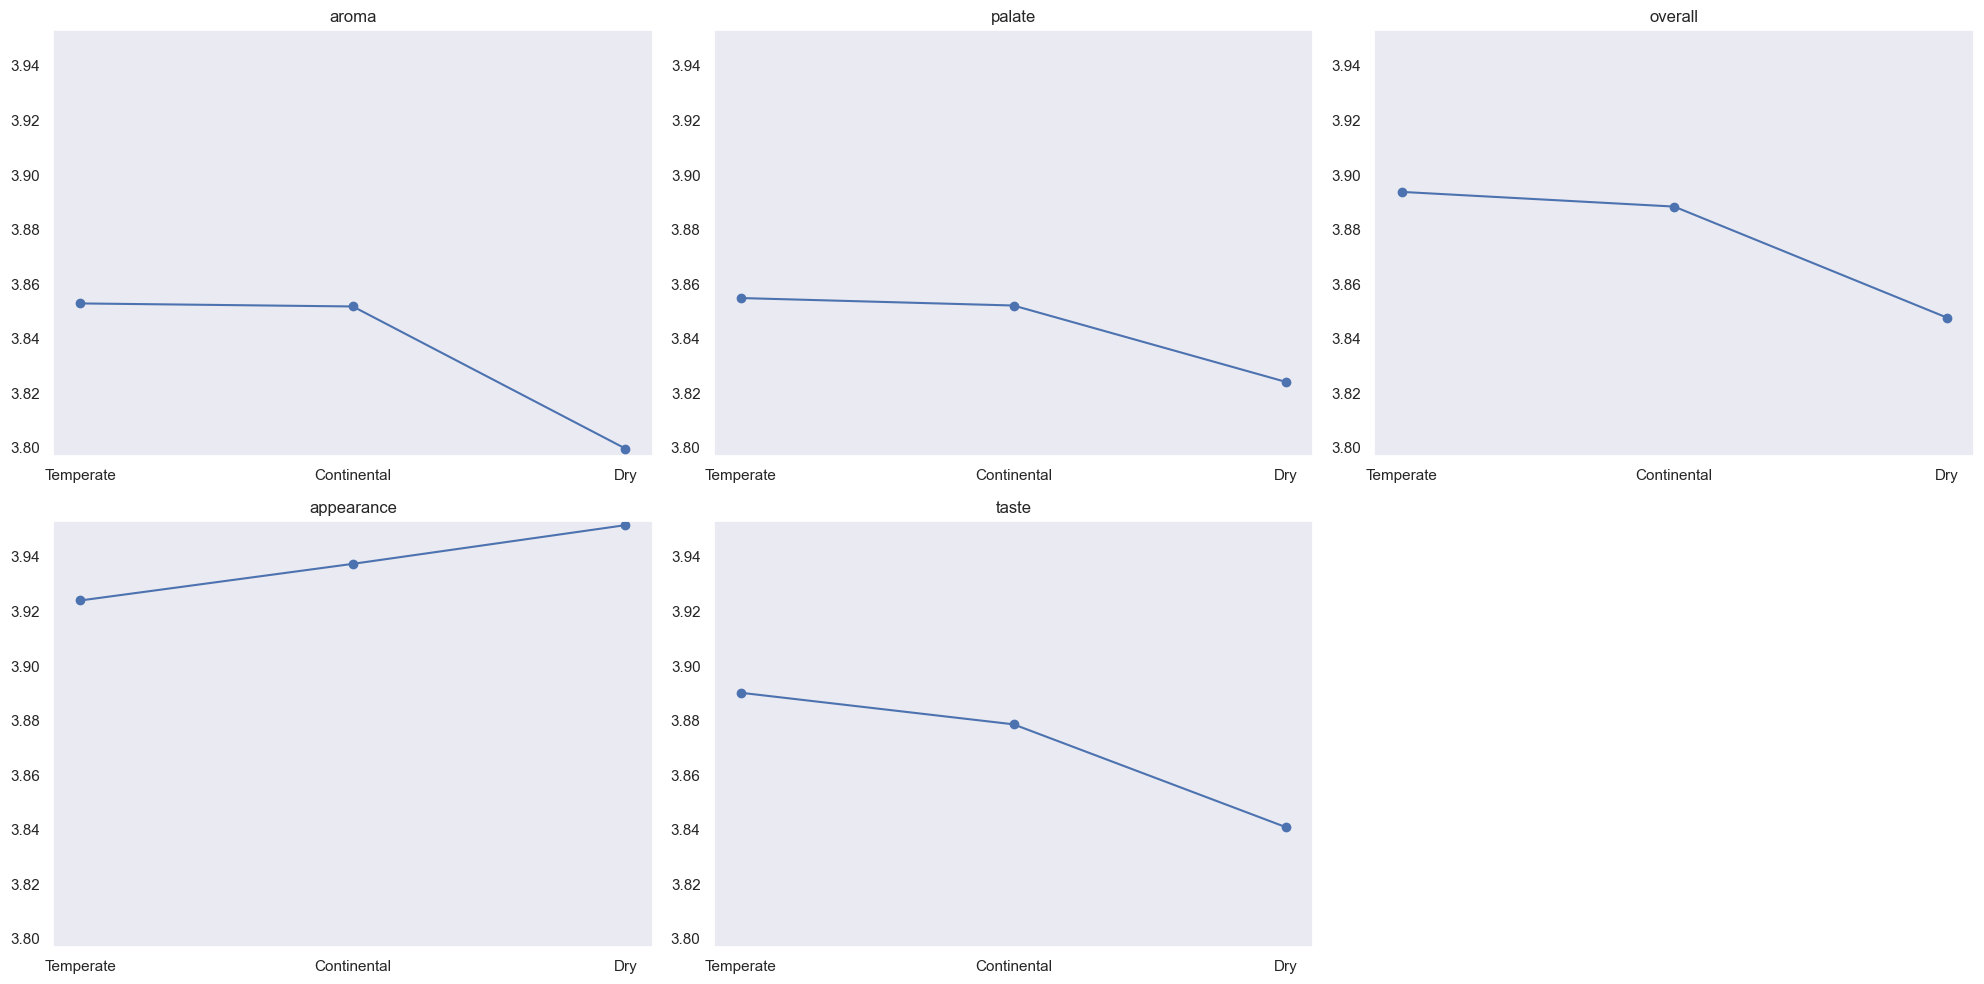

In [56]:
# Now let's analyze but using the climate_scheme column
climate_scheme_dfs = {}
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]
averages_scores = {}

for climate_s in climate_classifications["scheme"].unique():
    climate_scheme_dfs[climate_s] = us_users_ratings[us_users_ratings["climate_scheme"] == climate_s]
    
    for score in scores_to_compare:
        averages_scores[(climate_s, score)] = climate_scheme_dfs[climate_s][score].mean()
        
# Plot the average overall score for each climate
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

max_y_scale = 0
min_y_scale = 6

for i, score in enumerate(scores_to_compare):
    ax[i%2, i//2].plot([averages_scores[(climate_s, score)] for climate_s in climate_classifications["scheme"].unique()], "o-")
    ax[i%2, i//2].set_xticks(range(len(climate_classifications["scheme"].unique())))
    ax[i%2, i//2].set_xticklabels(climate_classifications["scheme"].unique())
    ax[i%2, i//2].set_title(score)
    ax[i%2, i//2].grid()
    
    if ax[i%2, i//2].get_ylim()[1] > max_y_scale:
        max_y_scale = ax[i%2, i//2].get_ylim()[1]
    if ax[i%2, i//2].get_ylim()[0] < min_y_scale:
        min_y_scale = ax[i%2, i//2].get_ylim()[0]
        
        
for i, score in enumerate(scores_to_compare):
    ax[i%2, i//2].set_ylim(min_y_scale, max_y_scale)

ax[1, 2].axis("off")    
plt.tight_layout()
plt.show()


In [58]:
for score in scores_to_compare:
    contingency_table = pd.crosstab(us_users_ratings["climate_scheme"], us_users_ratings[score])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print("Score:", score, "; p-value:", p)

Score: aroma ; p-value: 1.0991290603490593e-38
Score: appearance ; p-value: 1.7394357136527266e-52
Score: palate ; p-value: 7.648038295249008e-29
Score: taste ; p-value: 1.7962281611299406e-44
Score: overall ; p-value: 2.358910645578224e-35


## 3) First analysis : Correlation between climate and abv

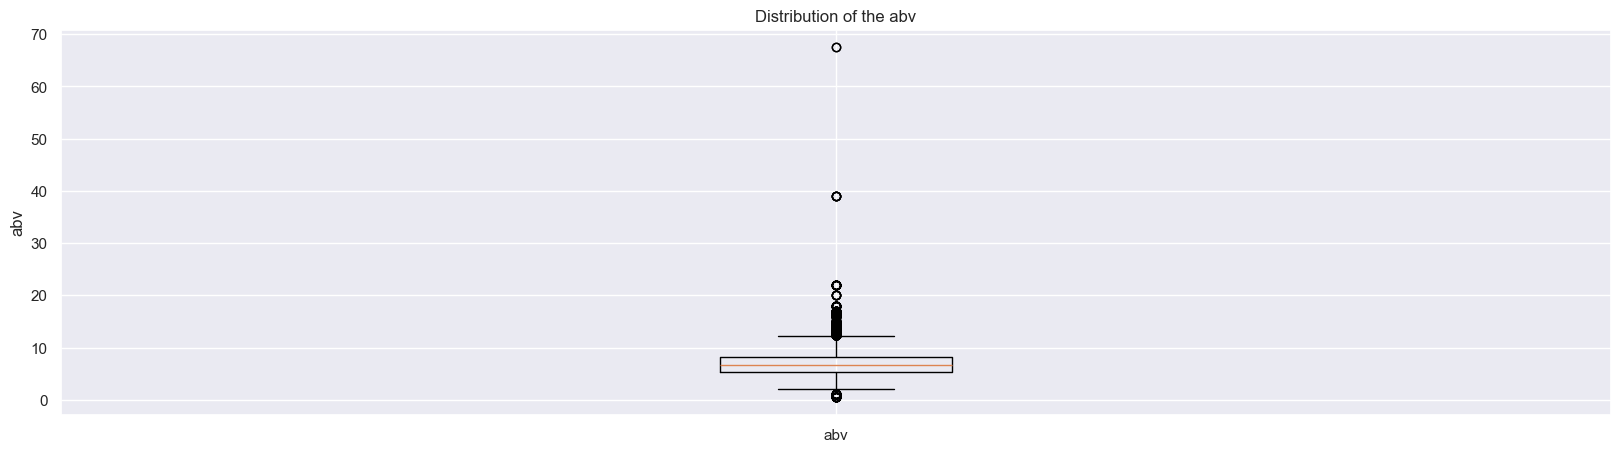

In [96]:
#boxplot of abv of the us
fig, ax = plt.subplots(figsize=(20, 5))
ax.boxplot(us_users_ratings["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()


In [100]:
#keep only the beers which have an abv between 0 and 95% (to remove outliers)
quantile_5 = us_users_ratings["abv"].quantile(0.05)
quantile_95 = us_users_ratings["abv"].quantile(0.95)

print("Shape before filtering:", us_users_ratings.shape)
us_abv_ratings = us_users_ratings[(us_users_ratings["abv"] > quantile_5) & (us_users_ratings["abv"] < quantile_95)]
print("Shape after filtering:", us_abv_ratings.shape)


Shape before filtering: (228194, 35)
Shape after filtering: (201096, 35)


In [102]:
#sort a dataframe with the name ot the climate
climate_names = pd.DataFrame(us_abv_ratings["climate"].unique(), columns=["climate"])

#to store the climate dataframes
climate_dataframes = {}

#create a for loop to create separate dataframes for each climate based on the climate_names
for climate in climate_names["climate"]:
    climate_df= pd.DataFrame(us_abv_ratings[us_abv_ratings["climate"] == climate].reset_index(drop=True))
    climate_dataframes[climate] = climate_df.sort_values(by="overall", ascending=False).reset_index(drop=True)

In [103]:
keeping_best_beers = {}
count_style_occurences = {}

#create new dataframes containign the best three beers for each climate
for climate, climate_df in climate_dataframes.items():
    us_grouped_beers = climate_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)
    
    #keep only the three best beers
    best_three = us_overall_means[:3]

    #count the number of occurences of each style of beer
    for beer in best_three.index:
        if beer not in count_style_occurences.keys():
            count_style_occurences[beer] = 1
        else:
            count_style_occurences[beer] += 1

    keeping_best_beers[climate] = climate_df[climate_df["general_style"].isin(best_three.index)].reset_index(drop=True)

print("Number of times a beer style appears in the top 3 beers of a climate: ")
display(count_style_occurences)


Number of times a beer style appears in the top 3 beers of a climate: 


{'Sour Ale': 10, 'IPA': 8, 'Stout': 9, 'Porter': 1, 'Brown Ale': 2}

In [104]:
us_abv_best_3 = pd.DataFrame(columns=["climate", "mean_abv_best"])

for climate in keeping_best_beers:
    #calculate the mean of the abv in the column abv of the dataframe 
    mean_abv_best = keeping_best_beers[climate]["abv"].mean()
    us_abv_best_3 = pd.concat([us_abv_best_3, pd.DataFrame([[climate, mean_abv_best]], columns=["climate", "mean_abv_best"])])
    
    
#add a column to climate_names with the average of the best 25% of beers in each climate
climate_names = climate_names.merge(us_abv_best_3, left_on="climate", right_on="climate")
climate_names.sort_values("mean_abv_best", ascending= False).head(10)


/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_15900/1527187863.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  us_abv_best_3 = pd.concat([us_abv_best_3, pd.DataFrame([[climate, mean_abv_best]], columns=["climate", "mean_abv_best"])])


,climate,mean_abv_best
2,Cfb,7.927700
1,Dfa,7.547539
0,Cfa,7.526973
3,Dfb,7.455169
7,Csa,7.400948
8,Dsb,7.392067
6,Bsk,7.374981
9,Dsc,7.353158
5,Csb,7.093543
4,Dfc,7.034567


In [105]:
keeping_most_reviewed_beers = {}
count_style_occurences = {}

for climate, climate_df in climate_dataframes.items():
    #get number of occurences of each style of beer
    num_reviews = climate_df["general_style"].value_counts()

    #keep only the 3 most reviewed beers
    most_reviewed = num_reviews[:3]

    #count the number of occurences of each style of beer
    for beer in most_reviewed.index:
        if beer not in count_style_occurences.keys():
            count_style_occurences[beer] = 1
        else:
            count_style_occurences[beer] += 1

    keeping_most_reviewed_beers[climate] = climate_df[climate_df["general_style"].isin(most_reviewed.index)].reset_index(drop=True)

print("Most reviewed beers for each climate:")
for climate in keeping_most_reviewed_beers:
    print("Climate {}: {}".format(climate, keeping_most_reviewed_beers[climate]["general_style"].unique()))

print("Number of occurences of each style of beer:")
display(count_style_occurences)
    

Most reviewed beers for each climate:
Climate Cfa: ['Brown Ale' 'Pale Ale' 'IPA']
Climate Dfa: ['Brown Ale' 'Pale Ale' 'IPA']
Climate Cfb: ['IPA' 'Lager' 'Pale Ale']
Climate Dfb: ['IPA' 'Brown Ale' 'Pale Ale']
Climate Dfc: ['Brown Ale' 'IPA' 'Pale Ale']
Climate Csb: ['Pale Ale' 'IPA' 'Brown Ale']
Climate Bsk: ['IPA' 'Brown Ale' 'Pale Ale']
Climate Csa: ['Pale Ale' 'IPA' 'Brown Ale']
Climate Dsb: ['Brown Ale' 'IPA' 'Pale Ale']
Climate Dsc: ['Pale Ale' 'IPA' 'Lager']
Number of occurences of each style of beer:


{'IPA': 10, 'Pale Ale': 10, 'Brown Ale': 8, 'Lager': 2}

In [106]:
us_abv_most_reviewed = pd.DataFrame(columns=["climate", "mean_abv_most"])

for climate in keeping_most_reviewed_beers:
    #calculate the mean of the abv in the column abv of the dataframe 
    mean_abv_most = keeping_most_reviewed_beers[climate]["abv"].mean()
    us_abv_most_reviewed = pd.concat([us_abv_most_reviewed, pd.DataFrame([[climate, mean_abv_most]], columns=["climate", "mean_abv_most"])])

#add a column to climate_names with the average of the most reviewed beers in each climate
climate_names = climate_names.merge(us_abv_most_reviewed, left_on="climate", right_on="climate")
climate_names.sort_values("mean_abv_most", ascending= False).head(10)

/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_15900/2970920554.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  us_abv_most_reviewed = pd.concat([us_abv_most_reviewed, pd.DataFrame([[climate, mean_abv_most]], columns=["climate", "mean_abv_most"])])


,climate,mean_abv_best,mean_abv_most
7,Csa,7.400948,7.032114
1,Dfa,7.547539,6.966462
0,Cfa,7.526973,6.932196
8,Dsb,7.392067,6.911417
4,Dfc,7.034567,6.867535
3,Dfb,7.455169,6.859069
6,Bsk,7.374981,6.845653
5,Csb,7.093543,6.779279
9,Dsc,7.353158,6.737406
2,Cfb,7.927700,6.659652


/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_15900/2257379994.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(us_abv_best_3["climate"], rotation=90)
/var/folders/0g/yd41q8010pn2lvl2qx960v240000gn/T/ipykernel_15900/2257379994.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(us_abv_most_reviewed["climate"], rotation=90)


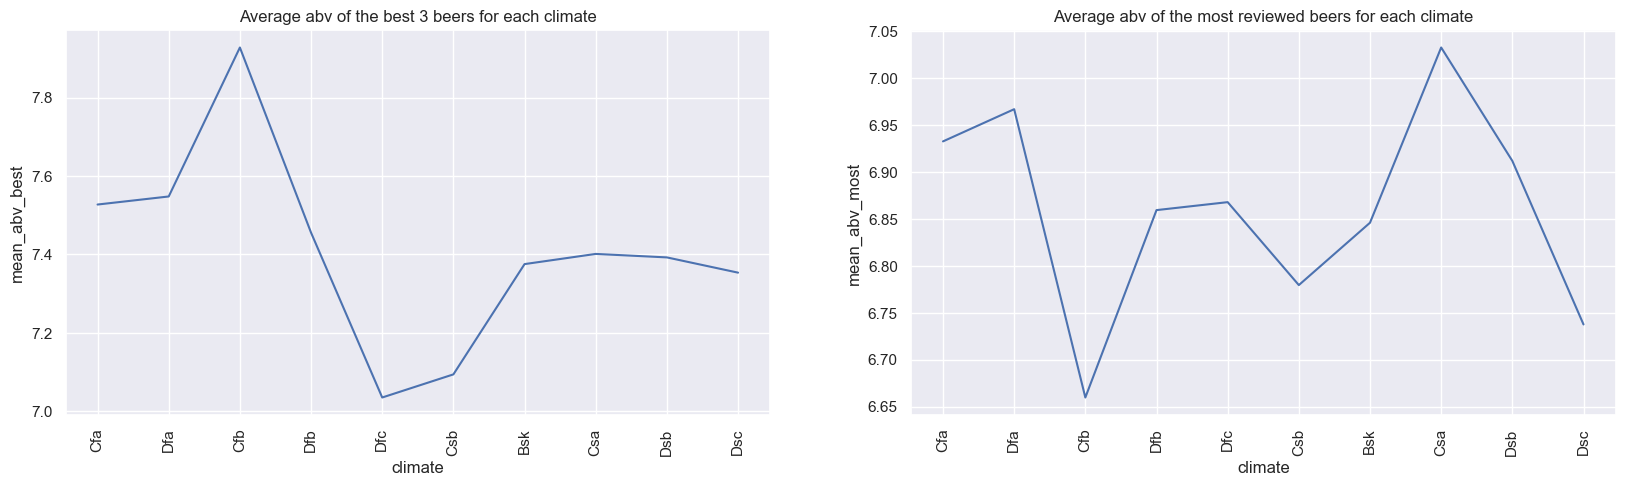

In [107]:
#plot the average abv of the best 3 beers and the most reviewed beers for each climate
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(x="climate", y="mean_abv_best", data=us_abv_best_3, ax=axs[0])
axs[0].set_xticklabels(us_abv_best_3["climate"], rotation=90)
axs[0].set_title("Average abv of the best 3 beers for each climate")
sns.lineplot(x="climate", y="mean_abv_most", data=us_abv_most_reviewed, ax=axs[1])
axs[1].set_xticklabels(us_abv_most_reviewed["climate"], rotation=90)
axs[1].set_title("Average abv of the most reviewed beers for each climate")
plt.show()

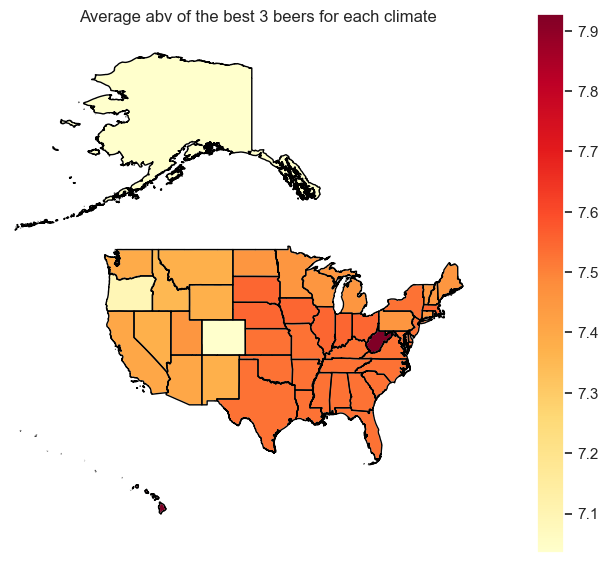

In [108]:
plot_climate_stats(climate_names, "mean_abv_best", "Average abv of the best 3 beers for each climate")

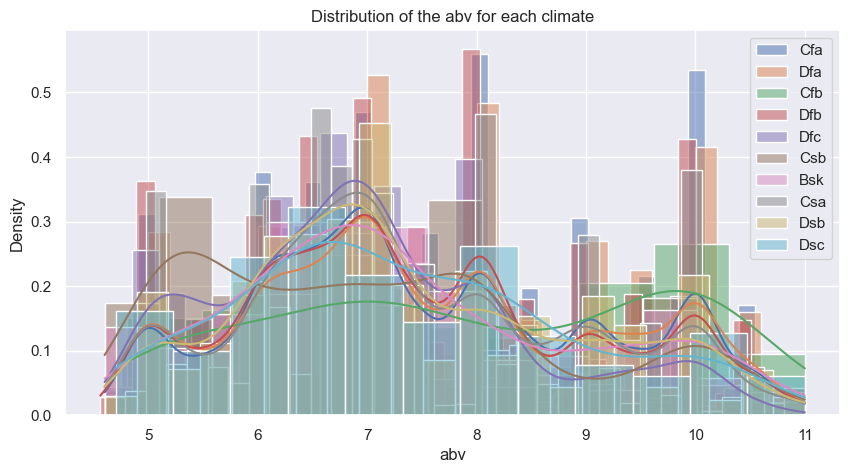

In [109]:
#plot the average abv of the best 3 beers and the most reviewed beers for each climate

# Use superimposed histograms
fig, ax = plt.subplots(figsize=(10, 5))

for climate in keeping_best_beers:
    sns.histplot(keeping_best_beers[climate]["abv"], ax=ax, label=climate, kde=True, stat="density")
ax.set_xlabel("abv")
ax.set_ylabel("Density")
ax.set_title("Distribution of the abv for each climate")
ax.legend()

In [110]:
# chi2 test to see if the distribution of the abv is the same for each climate
from scipy.stats import chi2_contingency

# First compute the contingency table
data_chi2 = pd.crosstab(us_abv_ratings["climate"], us_abv_ratings["abv"])

# Perform the chi2 test
chi2, p, dof, expected = chi2_contingency(data_chi2)
print("The p-value of the chi2 test is:", p)

The p-value of the chi2 test is: 0.0


In [111]:
# For each climate, look at if the best beers and the most reviewed beers have the same abv distribution
from scipy.stats import ttest_ind

for climate in keeping_best_beers:
    best_beers_abv = np.array(keeping_best_beers[climate]["abv"]).astype(float)
    most_reviewed_beers_abv = np.array(keeping_most_reviewed_beers[climate]["abv"]).astype(float)
    ttest = ttest_ind(best_beers_abv, most_reviewed_beers_abv)
    if ttest.pvalue > 0.05:
        print("Difference between best beers and most reviewed beers for climate {} is not significant".format(climate))

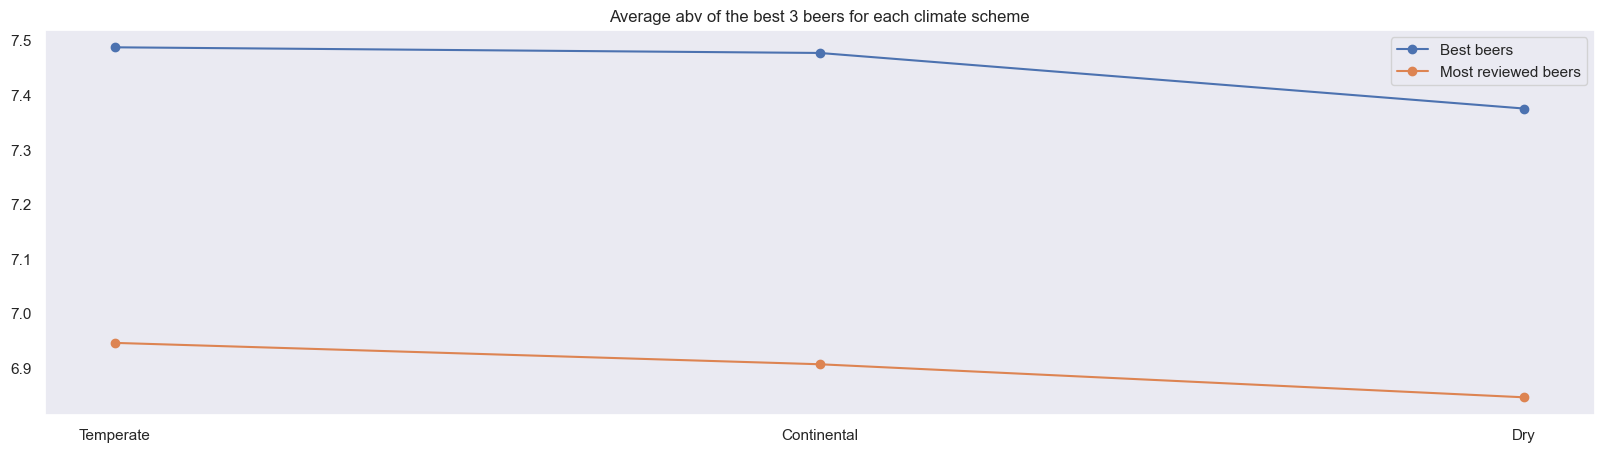

In [119]:
# Now test the climate scheme, as they are only three of them let's check their abv differences globally first
best_beers_scheme_dfs = {}
best_beers_scheme_abv = {}
most_reviewed_scheme_dfs = {}
most_reviewed_scheme_abv = {}

for climate_s in climate_classifications["scheme"].unique():
    climate_scheme_df = us_abv_ratings[us_abv_ratings["climate_scheme"] == climate_s]
    
    us_grouped_beers = climate_scheme_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)
    
    #keep only the three best beers
    best_three = us_overall_means[:3]
    
    #keep only the 3 most reviewed beers
    num_reviews = climate_scheme_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]
    
    best_beers_scheme_dfs[climate_s] = climate_scheme_df[climate_scheme_df["general_style"].isin(best_three.index)].reset_index(drop=True)
    best_beers_scheme_abv[climate_s] = best_beers_scheme_dfs[climate_s]["abv"].mean()
    
    most_reviewed_scheme_dfs[climate_s] = climate_scheme_df[climate_scheme_df["general_style"].isin(most_reviewed.index)].reset_index(drop=True)
    most_reviewed_scheme_abv[climate_s] = most_reviewed_scheme_dfs[climate_s]["abv"].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([best_beers_scheme_abv[climate_s] for climate_s in climate_classifications["scheme"].unique()], "o-", label="Best beers")
ax.plot([most_reviewed_scheme_abv[climate_s] for climate_s in climate_classifications["scheme"].unique()], "o-", label="Most reviewed beers")
ax.set_xticks(range(len(climate_classifications["scheme"].unique())), climate_classifications["scheme"].unique())
ax.set_title("Average abv of the best 3 beers for each climate scheme")
ax.grid()
ax.legend()
plt.show()
    

Overall average of best beers for climate without dry season: 3.984422044770258
Overall average of most reviewed beers for climate without dry season: 3.906171007803055
Overall average of best beers for climate with dry season: 3.954129215381496
Overall average of most reviewed beers for climate with dry season: 3.8719310670443816


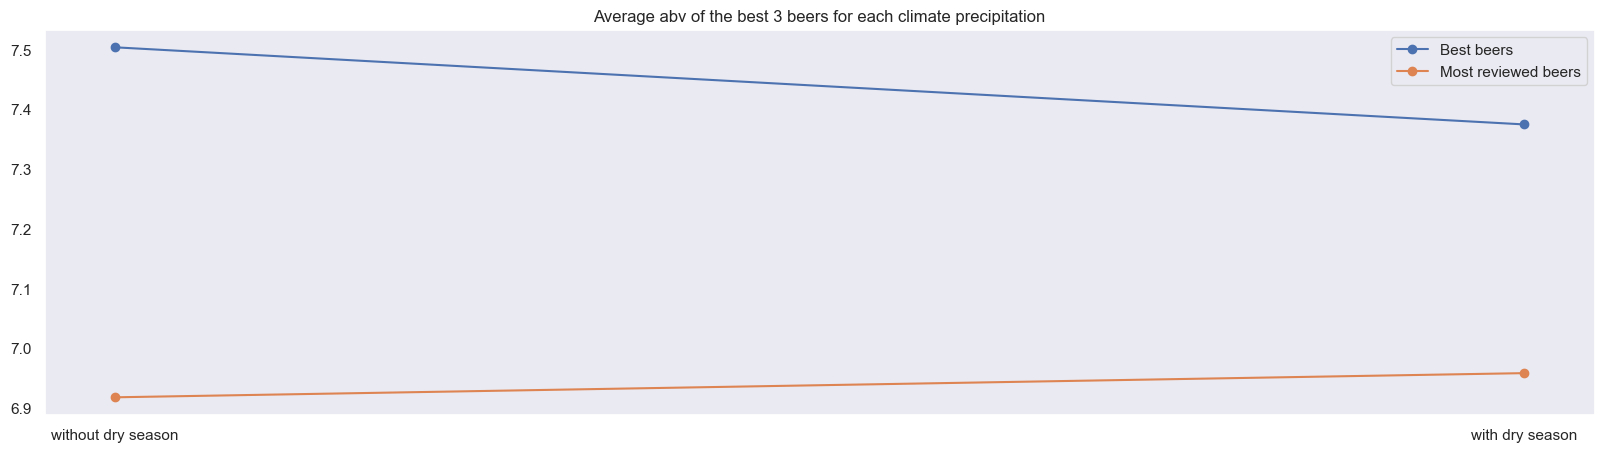

In [124]:
# Now test the climate precipitation, as there are multiple values, let's check their abv differences globally first
best_beers_precipitation_dfs = {}
best_beers_precipitation_abv = {}
most_reviewed_precipitation_dfs = {}
most_reviewed_precipitation_abv = {}

for climate_p in climate_classifications["seasonal_precipitation"].unique():
    climate_precipitation_df = us_abv_ratings[us_abv_ratings["climate_precipitation"] == climate_p]
    
    us_grouped_beers = climate_precipitation_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)
    
    #keep only the three best beers
    best_three = us_overall_means[:3]
    
    #keep only the 3 most reviewed beers
    num_reviews = climate_precipitation_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]
    
    best_beers_precipitation_dfs[climate_p] = climate_precipitation_df[climate_precipitation_df["general_style"].isin(best_three.index)].reset_index(drop=True)
    
    print("Overall average of best beers for climate {}: {}".format(climate_p, best_beers_precipitation_dfs[climate_p]["overall"].mean()))
    
    best_beers_precipitation_abv[climate_p] = best_beers_precipitation_dfs[climate_p]["abv"].mean()
    
    most_reviewed_precipitation_dfs[climate_p] = climate_precipitation_df[climate_precipitation_df["general_style"].isin(most_reviewed.index)].reset_index(drop=True)
    
    print("Overall average of most reviewed beers for climate {}: {}".format(climate_p, most_reviewed_precipitation_dfs[climate_p]["overall"].mean()))
    
    most_reviewed_precipitation_abv[climate_p] = most_reviewed_precipitation_dfs[climate_p]["abv"].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([best_beers_precipitation_abv[climate_p] for climate_p in climate_classifications["seasonal_precipitation"].unique()], "o-", label="Best beers")
ax.plot([most_reviewed_precipitation_abv[climate_p] for climate_p in climate_classifications["seasonal_precipitation"].unique()], "o-", label="Most reviewed beers")
ax.set_xticks(range(len(climate_classifications["seasonal_precipitation"].unique())), climate_classifications["seasonal_precipitation"].unique())
ax.set_title("Average abv of the best 3 beers for each climate precipitation")
ax.grid()
ax.legend()
plt.show()


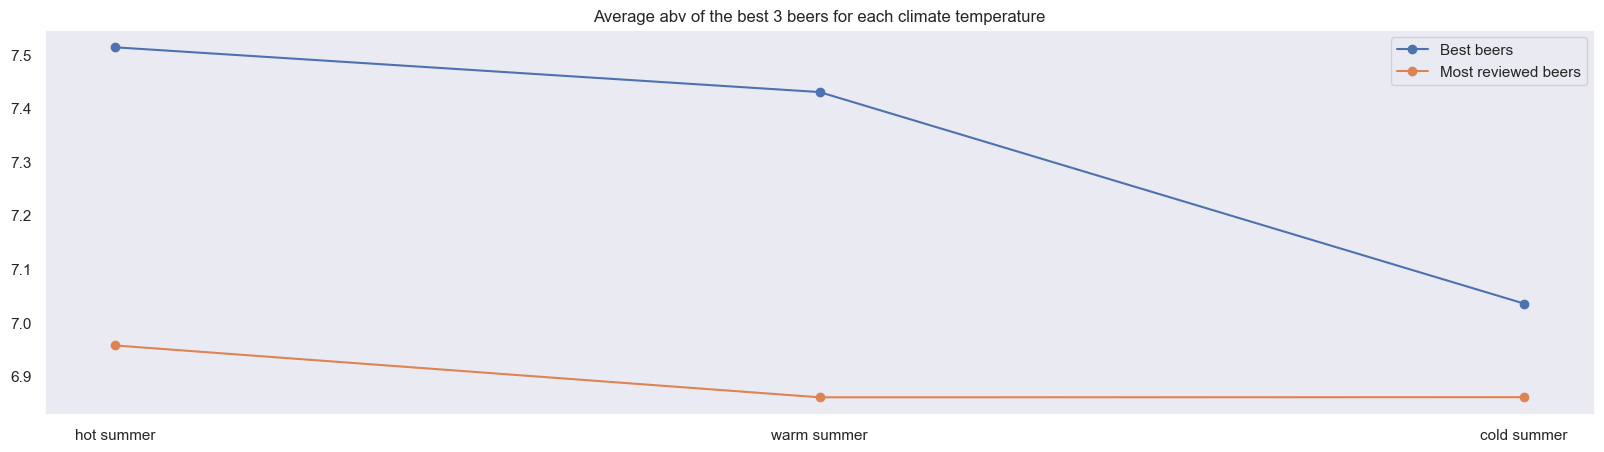

In [121]:
# Now test the climate temperature, as there are multiple values, let's check their abv differences globally first
best_beers_temperature_dfs = {}
best_beers_temperature_abv = {}
most_reviewed_temperature_dfs = {}
most_reviewed_temperature_abv = {}

for climate_t in climate_classifications["heat_level"].unique():
    climate_temperature_df = us_abv_ratings[us_abv_ratings["climate_temperature"] == climate_t]
    
    us_grouped_beers = climate_temperature_df.groupby("general_style")
    us_overall_means = us_grouped_beers["overall"].mean()
    us_overall_means = us_overall_means.sort_values(ascending=False)
    
    #keep only the three best beers
    best_three = us_overall_means[:3]
    
    #keep only the 3 most reviewed beers
    num_reviews = climate_temperature_df["general_style"].value_counts()
    most_reviewed = num_reviews[:3]
    
    best_beers_temperature_dfs[climate_t] = climate_temperature_df[climate_temperature_df["general_style"].isin(best_three.index)].reset_index(drop=True)
    best_beers_temperature_abv[climate_t] = best_beers_temperature_dfs[climate_t]["abv"].mean()
    
    most_reviewed_temperature_dfs[climate_t] = climate_temperature_df[climate_temperature_df["general_style"].isin(most_reviewed.index)].reset_index(drop=True)
    most_reviewed_temperature_abv[climate_t] = most_reviewed_temperature_dfs[climate_t]["abv"].mean()

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot([best_beers_temperature_abv[climate_t] for climate_t in climate_classifications["heat_level"].unique()], "o-", label="Best beers")
ax.plot([most_reviewed_temperature_abv[climate_t] for climate_t in climate_classifications["heat_level"].unique()], "o-", label="Most reviewed beers")
ax.set_xticks(range(len(climate_classifications["heat_level"].unique())), climate_classifications["heat_level"].unique())
ax.set_title("Average abv of the best 3 beers for each climate temperature")
ax.grid()
ax.legend()
plt.show()


## 3) Correlation between ratings and abv

In [126]:
rating_abv_df = us_abv_ratings.copy()

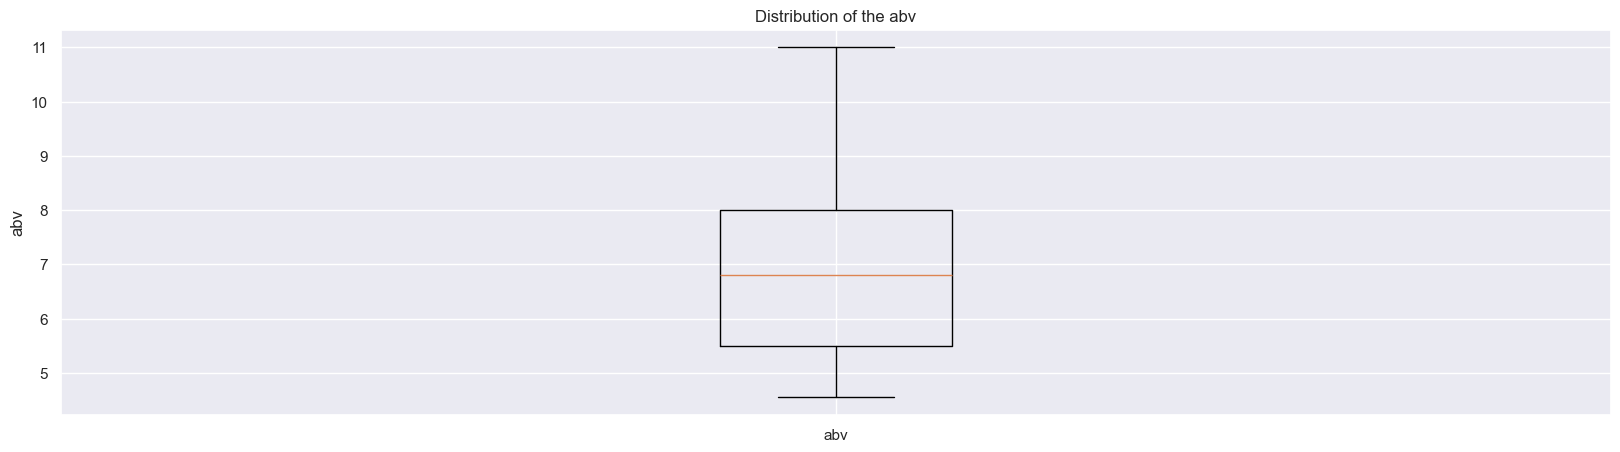

In [127]:
# Box plot of the abv
fig, ax = plt.subplots(figsize=(20, 5))
ax.boxplot(rating_abv_df["abv"])
ax.set_xticklabels(["abv"])
ax.set_ylabel("abv")
ax.set_title("Distribution of the abv")
plt.show()

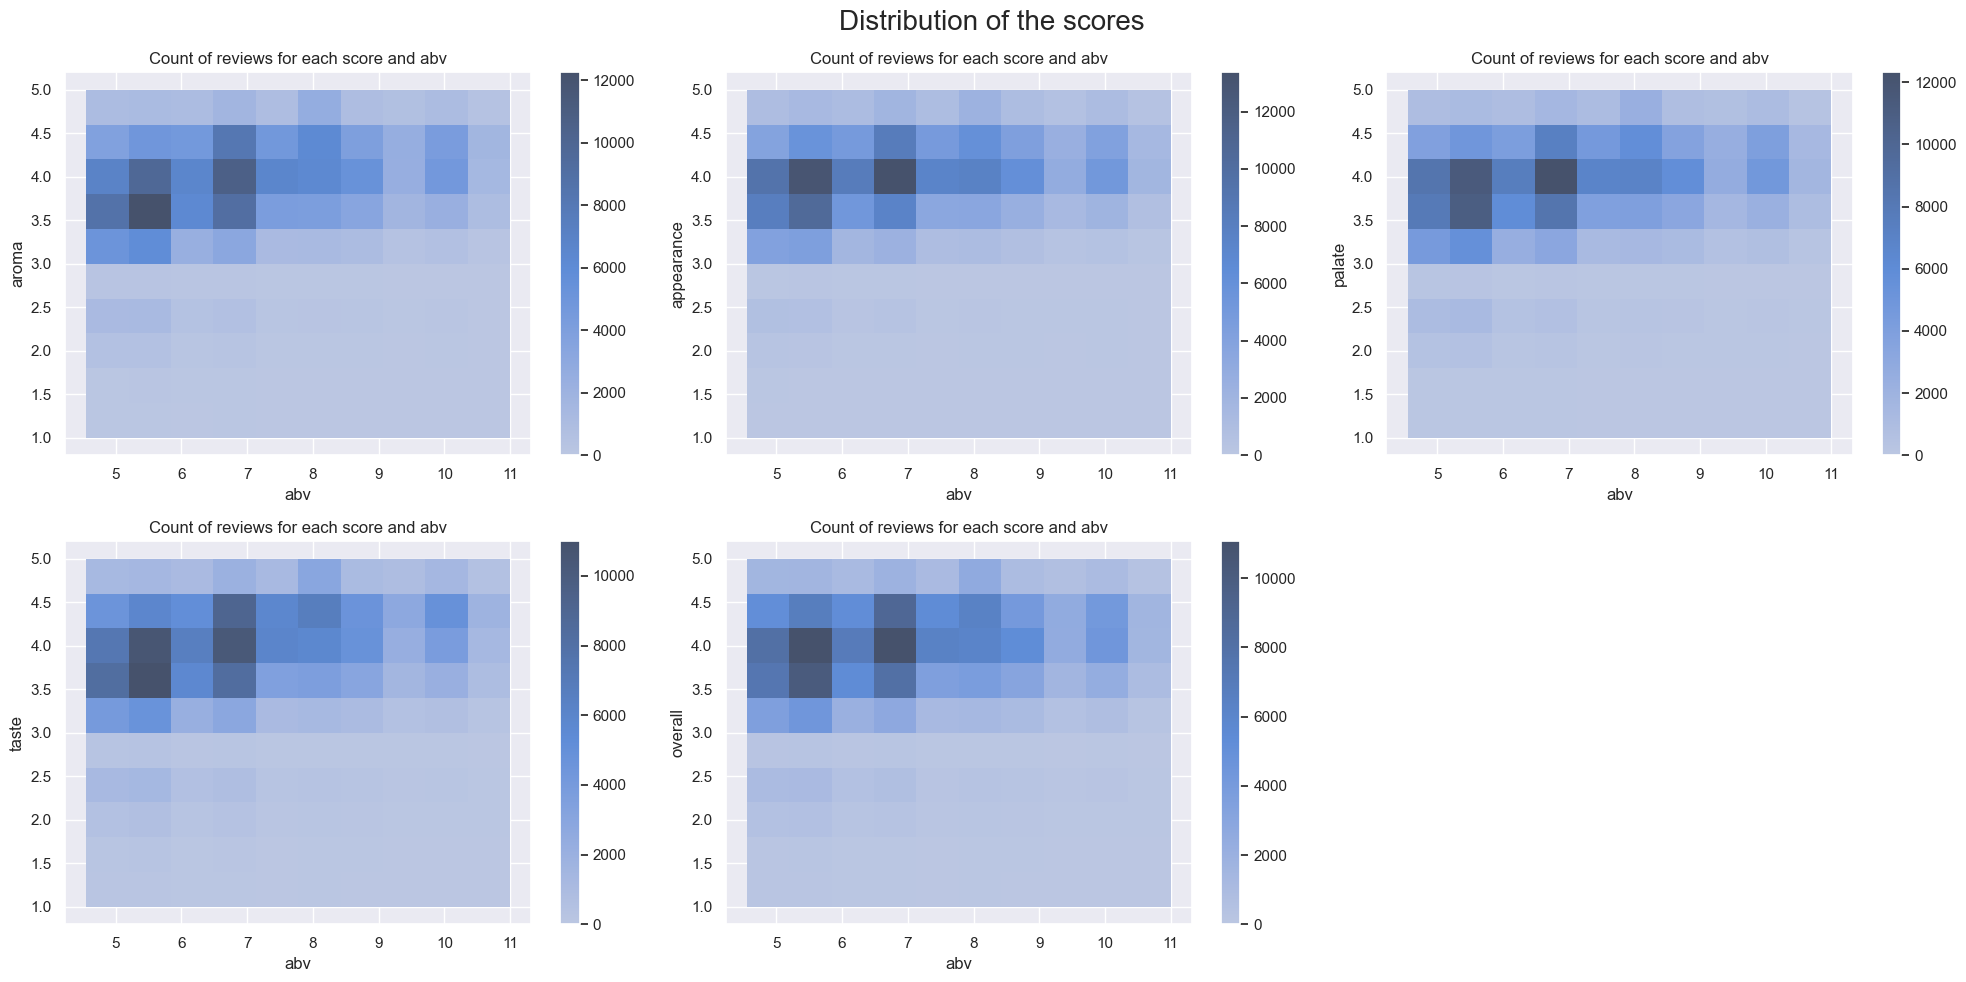

In [136]:
# 2D Histogram of the abv for each score
scores_to_compare = ["aroma", "appearance", "palate", "taste", "overall"]

fig, axs = plt.subplots(2, 3, figsize=(20, 10))

for i, score in enumerate(scores_to_compare):
    ax = axs[i // 3][i % 3]
    
    # Heat map of the abv for each score
    sns.histplot(rating_abv_df, x="abv", y=score, bins=10, cbar=True, ax=ax)
    ax.set_title("Count of reviews for each score and abv")
    
axs[1][2].set_visible(False)

fig.suptitle("Distribution of the scores", fontsize=20)
plt.tight_layout()
plt.show()

## 3) Text reviews baseline

Compute the average sentiment analysis score for us users and then average per state

In [55]:
saved = True

def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)  # We use the seed 42

#load spacy model and add pipeline to detect language
nlp_model = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)
nlp_model.add_pipe('spacytextblob')

if saved :
    print("retreiving language of text reviews from csv")
    us_users_txt = pd.read_csv("data/us_users_txt.csv")
else :
    #detect language of text reviews
    us_users_txt["language"] = us_users_txt["text"].apply(lambda x: nlp_model(x)._.language["language"])
    us_users_txt["polarity"] = us_users_txt["text"].apply(lambda x: nlp_model(x)._.blob.polarity)
    us_users_txt["subjectivity"] = us_users_txt["text"].apply(lambda x: nlp_model(x)._.blob.subjectivity)
    us_users_txt.to_csv("data/us_users_txt.csv")

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [ ]:
doc = us_users_txt["text"].iloc[0:4]
#detect language of text reviews and see how much time it takes
import time
start_time = time.time()
doc = doc.apply(lambda x: nlp_model(x)._.blob.polarity)
duration = (time.time() - start_time)
print("--- %s seconds ---" % duration)

print(len(us_users_txt["text"]), "duration ", len(us_users_txt["text"])/4/60/60, "heures")
print(doc)

In [ ]:
#compute sentiment analysis of text reviews